# Run PPO on Ant from [here](https://github.com/pat-coady/trpo)
#### More descriptions can be found on Patrick Coady's blog regarding [gym and ppo](https://learningai.io/projects/2017/07/28/ai-gym-workout.html) or [descriptions about Ant env](https://gist.github.com/pat-coady/bac60888f011199aad72d2f1e6f5a4fa)

In [1]:
import gym,mujoco_py,warnings,time,os,glob,shutil,csv
import scipy.signal
gym.logger.set_level(40)
warnings.filterwarnings("ignore") 
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from gym.envs import mujoco
from sklearn.utils import shuffle
from datetime import datetime
from util import PID_class
from custom_ant import AntEnvCustom
np.set_printoptions(precision=2,linewidth=150)
%matplotlib inline  
%config InlineBackend.figure_format = 'retina'
print ("Packages Loaded") 

Packages Loaded


### Scaler

In [2]:
class Scaler(object):
    """ Generate scale and offset based on running mean and stddev along axis=0
        offset = running mean
        scale = 1 / (stddev + 0.1) / 3 (i.e. 3x stddev = +/- 1.0)
    """
    def __init__(self,obs_dim):
        self.vars = np.zeros(obs_dim)
        self.means = np.zeros(obs_dim)
        self.m = 0
        self.n = 0
        self.first_pass = True
    def update(self, x):
        """ Update running mean and variance (this is an exact method)
        Args:
            x: NumPy array, shape = (N, obs_dim)
        see: https://stats.stackexchange.com/questions/43159/how-to-calculate-pooled-
               variance-of-two-groups-given-known-group-variances-mean
        """
        if self.first_pass:
            self.means = np.mean(x, axis=0)
            self.vars = np.var(x, axis=0)
            self.m = x.shape[0]
            self.first_pass = False
        else:
            n = x.shape[0] # Number of data 
            new_data_var = np.var(x, axis=0)
            new_data_mean = np.mean(x, axis=0)
            new_data_mean_sq = np.square(new_data_mean)
            new_means = ((self.means * self.m) + (new_data_mean * n)) / (self.m + n)
            self.vars = (((self.m * (self.vars + np.square(self.means))) +
                          (n * (new_data_var + new_data_mean_sq))) / (self.m + n) -
                         np.square(new_means))
            self.vars = np.maximum(0.0, self.vars)  # occasionally goes negative, clip
            self.means = new_means
            self.m += n # Total number of data
    def get(self):
        """ returns 2-tuple: (scale, offset) """
        return 1/(np.sqrt(self.vars) + 0.1)/3, self.means

### Value function

In [3]:
class NNValueFunction(object):
    """ NN-based state-value function """
    def __init__(self, obs_dim, hid1_mult):
        """
        Args:
            obs_dim: number of dimensions in observation vector (int)
            hid1_mult: size of first hidden layer, multiplier of obs_dim
        """
        self.replay_buffer_x = None
        self.replay_buffer_y = None
        self.obs_dim = obs_dim
        self.hid1_mult = hid1_mult
        self.epochs = 10
        self.lr = None  # learning rate set in _build_graph()
        self._build_graph()
        self.sess = tf.Session(graph=self.g)
        self.sess.run(self.init)

    def _build_graph(self):
        """ Construct TensorFlow graph, including loss function, init op and train op """
        self.g = tf.Graph()
        with self.g.as_default():
            self.obs_ph = tf.placeholder(tf.float32, (None, self.obs_dim), 'obs_valfunc')
            self.val_ph = tf.placeholder(tf.float32, (None,), 'val_valfunc')
            # hid1 layer size is 10x obs_dim, hid3 size is 10, and hid2 is geometric mean
            hid1_size = self.obs_dim * self.hid1_mult  # default multipler 10 chosen empirically on 'Hopper-v1'
            hid3_size = 5  # 5 chosen empirically on 'Hopper-v1'
            hid2_size = int(np.sqrt(hid1_size * hid3_size))
            # heuristic to set learning rate based on NN size (tuned on 'Hopper-v1')
            self.lr = 1e-2 / np.sqrt(hid2_size)  # 1e-3 empirically determined
            print('Value Params -- h1: {}, h2: {}, h3: {}, lr: {:.3g}'
                  .format(hid1_size, hid2_size, hid3_size, self.lr))
            # 3 hidden layers with tanh activations
            out = tf.layers.dense(self.obs_ph, hid1_size, tf.tanh,
                                  kernel_initializer=tf.random_normal_initializer(
                                      stddev=np.sqrt(1 / self.obs_dim)), name="h1")
            out = tf.layers.dense(out, hid2_size, tf.tanh,
                                  kernel_initializer=tf.random_normal_initializer(
                                      stddev=np.sqrt(1 / hid1_size)), name="h2")
            out = tf.layers.dense(out, hid3_size, tf.tanh,
                                  kernel_initializer=tf.random_normal_initializer(
                                      stddev=np.sqrt(1 / hid2_size)), name="h3")
            out = tf.layers.dense(out, 1,
                                  kernel_initializer=tf.random_normal_initializer(
                                      stddev=np.sqrt(1 / hid3_size)), name='output')
            self.out = tf.squeeze(out)
            self.loss = tf.reduce_mean(tf.square(self.out - self.val_ph))  # squared loss
            optimizer = tf.train.AdamOptimizer(self.lr)
            self.train_op = optimizer.minimize(self.loss)
            self.init = tf.global_variables_initializer()
        self.sess = tf.Session(graph=self.g)
        self.sess.run(self.init)

    def fit(self, x, y, logger):
        """ Fit model to current data batch + previous data batch

        Args:
            x: features
            y: target
            logger: logger to save training loss and % explained variance
        """
        num_batches = max(x.shape[0] // 256, 1)
        batch_size = x.shape[0] // num_batches
        y_hat = self.predict(x)  # check explained variance prior to update
        old_exp_var = 1 - np.var(y - y_hat)/np.var(y)
        if self.replay_buffer_x is None:
            x_train, y_train = x, y
        else:
            x_train = np.concatenate([x, self.replay_buffer_x])
            y_train = np.concatenate([y, self.replay_buffer_y])
        self.replay_buffer_x = x
        self.replay_buffer_y = y
        for e in range(self.epochs):
            x_train, y_train = shuffle(x_train, y_train)
            for j in range(num_batches):
                start = j * batch_size
                end = (j + 1) * batch_size
                feed_dict = {self.obs_ph: x_train[start:end, :],
                             self.val_ph: y_train[start:end]}
                _, l = self.sess.run([self.train_op, self.loss], feed_dict=feed_dict)
        y_hat = self.predict(x)
        loss = np.mean(np.square(y_hat - y))         # explained variance after update
        exp_var = 1 - np.var(y - y_hat) / np.var(y)  # diagnose over-fitting of val func

        logger.log({'ValFuncLoss': loss,
                    'ExplainedVarNew': exp_var,
                    'ExplainedVarOld': old_exp_var})

    def predict(self, x):
        """ Predict method """
        feed_dict = {self.obs_ph: x}
        y_hat = self.sess.run(self.out, feed_dict=feed_dict)

        return np.squeeze(y_hat)

    def close_sess(self):
        """ Close TensorFlow session """
        self.sess.close()

### Policy function

In [4]:
class Policy(object):
    """ NN-based policy approximation """
    def __init__(self, obs_dim, act_dim, kl_targ, hid1_mult, policy_logvar, clipping_range=None):
        """
        Args:
            obs_dim: num observation dimensions (int)
            act_dim: num action dimensions (int)
            kl_targ: target KL divergence between pi_old and pi_new
            hid1_mult: size of first hidden layer, multiplier of obs_dim
            policy_logvar: natural log of initial policy variance
        """
        self.beta = 1.0  # dynamically adjusted D_KL loss multiplier
        self.eta = 50  # multiplier for D_KL-kl_targ hinge-squared loss
        self.kl_targ = kl_targ
        self.hid1_mult = hid1_mult
        self.policy_logvar = policy_logvar
        self.epochs = 20
        self.lr = None
        self.lr_multiplier = 1.0  # dynamically adjust lr when D_KL out of control
        self.obs_dim = obs_dim
        self.act_dim = act_dim
        self.clipping_range = clipping_range
        self._build_graph()
        self._init_session()

    def _build_graph(self):
        """ Build and initialize TensorFlow graph """
        self.g = tf.Graph()
        with self.g.as_default():
            self._placeholders()
            self._policy_nn()
            self._logprob()
            self._kl_entropy()
            self._sample()
            self._loss_train_op()
            self.init = tf.global_variables_initializer()

    def _placeholders(self):
        """ Input placeholders"""
        # observations, actions and advantages:
        self.obs_ph = tf.placeholder(tf.float32, (None, self.obs_dim), 'obs')
        self.act_ph = tf.placeholder(tf.float32, (None, self.act_dim), 'act')
        self.advantages_ph = tf.placeholder(tf.float32, (None,), 'advantages')
        # strength of D_KL loss terms:
        self.beta_ph = tf.placeholder(tf.float32, (), 'beta')
        self.eta_ph = tf.placeholder(tf.float32, (), 'eta')
        # learning rate:
        self.lr_ph = tf.placeholder(tf.float32, (), 'eta')
        # log_vars and means with pi_old (previous step's policy parameters):
        self.old_log_vars_ph = tf.placeholder(tf.float32, (self.act_dim,), 'old_log_vars')
        self.old_means_ph = tf.placeholder(tf.float32, (None, self.act_dim), 'old_means')

    def _policy_nn(self):
        """ Neural net for policy approximation function

        Policy parameterized by Gaussian means and variances. NN outputs mean
         action based on observation. Trainable variables hold log-variances
         for each action dimension (i.e. variances not determined by NN).
        """
        # hidden layer sizes determined by obs_dim and act_dim (hid2 is geometric mean)
        hid1_size = self.obs_dim * self.hid1_mult  # 10 empirically determined
        hid3_size = self.act_dim * 10  # 10 empirically determined
        hid2_size = int(np.sqrt(hid1_size * hid3_size))
        # heuristic to set learning rate based on NN size (tuned on 'Hopper-v1')
        self.lr = 9e-4 / np.sqrt(hid2_size)  # 9e-4 empirically determined
        # 3 hidden layers with tanh activations
        out = tf.layers.dense(self.obs_ph, hid1_size, tf.tanh,
                              kernel_initializer=tf.random_normal_initializer(
                                  stddev=np.sqrt(1 / self.obs_dim)), name="h1")
        out = tf.layers.dense(out, hid2_size, tf.tanh,
                              kernel_initializer=tf.random_normal_initializer(
                                  stddev=np.sqrt(1 / hid1_size)), name="h2")
        out = tf.layers.dense(out, hid3_size, tf.tanh,
                              kernel_initializer=tf.random_normal_initializer(
                                  stddev=np.sqrt(1 / hid2_size)), name="h3")
        self.means = tf.layers.dense(out, self.act_dim,
                                     kernel_initializer=tf.random_normal_initializer(
                                         stddev=np.sqrt(1 / hid3_size)), name="means")
        # logvar_speed is used to 'fool' gradient descent into making faster updates
        # to log-variances. heuristic sets logvar_speed based on network size.
        logvar_speed = (10 * hid3_size) // 48
        log_vars = tf.get_variable('logvars', (logvar_speed, self.act_dim), tf.float32,
                                   tf.constant_initializer(0.0))
        self.log_vars = tf.reduce_sum(log_vars, axis=0) + self.policy_logvar

        print('Policy Params -- h1: {}, h2: {}, h3: {}, lr: {:.3g}, logvar_speed: {}'
              .format(hid1_size, hid2_size, hid3_size, self.lr, logvar_speed))

    def _logprob(self):
        """ Calculate log probabilities of a batch of observations & actions

        Calculates log probabilities using previous step's model parameters and
        new parameters being trained.
        """
        logp = -0.5 * tf.reduce_sum(self.log_vars)
        logp += -0.5 * tf.reduce_sum(tf.square(self.act_ph - self.means) /
                                     tf.exp(self.log_vars), axis=1)
        self.logp = logp

        logp_old = -0.5 * tf.reduce_sum(self.old_log_vars_ph)
        logp_old += -0.5 * tf.reduce_sum(tf.square(self.act_ph - self.old_means_ph) /
                                         tf.exp(self.old_log_vars_ph), axis=1)
        self.logp_old = logp_old

    def _kl_entropy(self):
        """
        Add to Graph:
            1. KL divergence between old and new distributions
            2. Entropy of present policy given states and actions

        https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Kullback.E2.80.93Leibler_divergence
        https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Entropy
        """
        log_det_cov_old = tf.reduce_sum(self.old_log_vars_ph)
        log_det_cov_new = tf.reduce_sum(self.log_vars)
        tr_old_new = tf.reduce_sum(tf.exp(self.old_log_vars_ph - self.log_vars))

        self.kl = 0.5 * tf.reduce_mean(log_det_cov_new - log_det_cov_old + tr_old_new +
                                       tf.reduce_sum(tf.square(self.means - self.old_means_ph) /
                                                     tf.exp(self.log_vars), axis=1) -
                                       self.act_dim)
        self.entropy = 0.5 * (self.act_dim * (np.log(2 * np.pi) + 1) +
                              tf.reduce_sum(self.log_vars))

    def _sample(self):
        """ Sample from distribution, given observation """
        self.sampled_act = (self.means +
                            tf.exp(self.log_vars / 2.0) *
                            tf.random_normal(shape=(self.act_dim,)))

    def _loss_train_op(self):
        """
        Three loss terms:
            1) standard policy gradient
            2) D_KL(pi_old || pi_new)
            3) Hinge loss on [D_KL - kl_targ]^2

        See: https://arxiv.org/pdf/1707.02286.pdf
        """
        if self.clipping_range is not None:
            print('setting up loss with clipping objective')
            pg_ratio = tf.exp(self.logp - self.logp_old)
            clipped_pg_ratio = tf.clip_by_value(pg_ratio, 1 - self.clipping_range[0], 1 + self.clipping_range[1])
            surrogate_loss = tf.minimum(self.advantages_ph * pg_ratio,
                                        self.advantages_ph * clipped_pg_ratio)
            self.loss = -tf.reduce_mean(surrogate_loss)
        else:
            print('setting up loss with KL penalty') # <= We use this 
            loss1 = -tf.reduce_mean(self.advantages_ph *
                                    tf.exp(self.logp - self.logp_old))
            loss2 = tf.reduce_mean(self.beta_ph * self.kl)
            loss3 = self.eta_ph * tf.square(tf.maximum(0.0, self.kl - 2.0*self.kl_targ))
            self.loss = loss1 + loss2 + loss3
        optimizer = tf.train.AdamOptimizer(self.lr_ph)
        self.train_op = optimizer.minimize(self.loss)

    def _init_session(self):
        """Launch TensorFlow session and initialize variables"""
        self.sess = tf.Session(graph=self.g)
        self.sess.run(self.init)

    def sample(self, obs):
        """Draw sample from policy distribution"""
        feed_dict = {self.obs_ph: obs}

        return self.sess.run(self.sampled_act, feed_dict=feed_dict)

    def update(self, observes, actions, advantages, logger):
        """ Update policy based on observations, actions and advantages

        Args:
            observes: observations, shape = (N, obs_dim)
            actions: actions, shape = (N, act_dim)
            advantages: advantages, shape = (N,)
            logger: Logger object, see utils.py
        """
        feed_dict = {self.obs_ph: observes,
                     self.act_ph: actions,
                     self.advantages_ph: advantages,
                     self.beta_ph: self.beta,
                     self.eta_ph: self.eta,
                     self.lr_ph: self.lr * self.lr_multiplier}
        old_means_np, old_log_vars_np = self.sess.run([self.means, self.log_vars],
                                                      feed_dict)
        feed_dict[self.old_log_vars_ph] = old_log_vars_np
        feed_dict[self.old_means_ph] = old_means_np
        loss, kl, entropy = 0, 0, 0
        for e in range(self.epochs):
            # TODO: need to improve data pipeline - re-feeding data every epoch
            self.sess.run(self.train_op, feed_dict)
            loss, kl, entropy = self.sess.run([self.loss, self.kl, self.entropy], feed_dict)
            if kl > self.kl_targ * 4:  # early stopping if D_KL diverges badly
                break
        # TODO: too many "magic numbers" in next 8 lines of code, need to clean up
        if kl > self.kl_targ * 2:  # servo beta to reach D_KL target
            self.beta = np.minimum(35, 1.5 * self.beta)  # max clip beta
            if self.beta > 30 and self.lr_multiplier > 0.1:
                self.lr_multiplier /= 1.5
        elif kl < self.kl_targ / 2:
            self.beta = np.maximum(1 / 35, self.beta / 1.5)  # min clip beta
            if self.beta < (1 / 30) and self.lr_multiplier < 10:
                self.lr_multiplier *= 1.5

        logger.log({'PolicyLoss': loss,
                    'PolicyEntropy': entropy,
                    'KL': kl,
                    'Beta': self.beta,
                    '_lr_multiplier': self.lr_multiplier})

    def close_sess(self):
        """ Close TensorFlow session """
        self.sess.close()

### Logger

In [5]:
class Logger(object):
    """ Simple training logger: saves to file and optionally prints to stdout """
    def __init__(self, logname, now):
        """
        Args:
            logname: name for log (e.g. 'Hopper-v1')
            now: unique sub-directory name (e.g. date/time string)
        """
        path = os.path.join('log-files', logname, now)
        os.makedirs(path)
        filenames = glob.glob('*.py')  # put copy of all python files in log_dir
        for filename in filenames:     # for reference
            shutil.copy(filename, path)
        path = os.path.join(path, 'log.csv')

        self.write_header = True
        self.log_entry = {}
        self.f = open(path, 'w')
        self.writer = None  # DictWriter created with first call to write() method

    def write(self, display=True):
        """ Write 1 log entry to file, and optionally to stdout
        Log fields preceded by '_' will not be printed to stdout

        Args:
            display: boolean, print to stdout
        """
        if display:
            self.disp(self.log_entry)
        if self.write_header:
            fieldnames = [x for x in self.log_entry.keys()]
            self.writer = csv.DictWriter(self.f, fieldnames=fieldnames)
            self.writer.writeheader()
            self.write_header = False
        self.writer.writerow(self.log_entry)
        self.log_entry = {}

    @staticmethod
    def disp(log):
        """Print metrics to stdout"""
        log_keys = [k for k in log.keys()]
        log_keys.sort()
        print('***** Episode {}, Mean R = {:.1f} *****'.format(log['_Episode'],
                                                               log['_MeanReward']))
        for key in log_keys:
            if key[0] != '_':  # don't display log items with leading '_'
                print('{:s}: {:.3g}'.format(key, log[key]))
        print('\n')

    def log(self, items):
        """ Update fields in log (does not write to file, used to collect updates.

        Args:
            items: dictionary of items to update
        """
        self.log_entry.update(items)

    def close(self):
        """ Close log file - log cannot be written after this """
        self.f.close()

### Run policy (run_episode & run_policy)

In [6]:
def run_episode(env, policy, scaler, animate=False):
    """ Run single episode with option to animate

    Args:
        env: ai gym environment
        policy: policy object with sample() method
        scaler: scaler object, used to scale/offset each observation dimension
            to a similar range
        animate: boolean, True uses env.render() method to animate episode

    Returns: 4-tuple of NumPy arrays
        observes: shape = (episode len, obs_dim)
        actions: shape = (episode len, act_dim)
        rewards: shape = (episode len,)
        unscaled_obs: useful for training scaler, shape = (episode len, obs_dim)
    """
    obs = env.reset()
    observes, actions, rewards, unscaled_obs = [], [], [], []
    done = False
    step = 0.0
    scale, offset = scaler.get()
    scale[-1] = 1.0  # don't scale time step feature
    offset[-1] = 0.0  # don't offset time step feature
    tick = 0
    while not done:
        if animate:
            env.render()
        obs = obs.astype(np.float32).reshape((1, -1)) # Make rank two
        obs = np.append(obs, [[step]], axis=1)  # add time step feature
        unscaled_obs.append(obs)
        # Normalize observations
        obs = (obs - offset) * scale  # center and scale observations
        observes.append(obs)
        # Sample action and make it rank two 
        action = policy.sample(obs).reshape((1, -1)).astype(np.float32)
        actions.append(action)
        # Forward step 
        obs, reward, done, _ = env.step(np.squeeze(action, axis=0))
        if not isinstance(reward, float):
            rwd_before = reward
            rwd_after = np.asscalar(reward)
            reward = rwd_after
            print ('rwd: %s => %s'%(rwd_before,rwd_after))
        rewards.append(reward)
        step += 1e-3  # increment time step feature
        tick += 1
        sec = env.sim.data.time # Get time [sec]
        # print ("tick:[%d] step:[%.2f] sec:[%.2fsec]"%(tick,step,sec))
        if sec > 10.0:
            done = True
    # Return (scaled) observations, actions, rewards, and unscaled obersavtions 
    return (np.concatenate(observes), np.concatenate(actions),
            np.array(rewards, dtype=np.float64), np.concatenate(unscaled_obs))

def run_policy(env, policy, scaler, logger, episodes):
    """ Run policy and collect data for a minimum of min_steps and min_episodes

    Args:
        env: ai gym environment
        policy: policy object with sample() method
        scaler: scaler object, used to scale/offset each observation dimension
            to a similar range
        logger: logger object, used to save stats from episodes
        episodes: total episodes to run

    Returns: list of trajectory dictionaries, list length = number of episodes
        'observes' : NumPy array of states from episode
        'actions' : NumPy array of actions from episode
        'rewards' : NumPy array of (un-discounted) rewards from episode
        'unscaled_obs' : NumPy array of (un-discounted) rewards from episode
    """
    total_steps = 0
    trajectories = [] # Empty list 
    for e in range(episodes):
        # print ("epi:[%d/%d]"%(e,episodes))
        observes, actions, rewards, unscaled_obs = run_episode(env, policy, scaler)
        total_steps += observes.shape[0]
        trajectory = {'observes': observes,
                      'actions': actions,
                      'rewards': rewards,
                      'unscaled_obs': unscaled_obs}
        trajectories.append(trajectory)
    unscaled = np.concatenate([t['unscaled_obs'] for t in trajectories])
    scaler.update(unscaled)  # update running statistics for scaling observations
    logger.log({'_MeanReward': np.mean([t['rewards'].sum() for t in trajectories]),
                'Steps': total_steps})
    return trajectories

### PPO

In [7]:
def add_value(trajectories, val_func):
    """ Adds estimated value to all time steps of all trajectories

    Args:
        trajectories: as returned by run_policy()
        val_func: object with predict() method, takes observations
            and returns predicted state value

    Returns:
        None (mutates trajectories dictionary to add 'values')
    """
    for trajectory in trajectories:
        observes = trajectory['observes']
        values = val_func.predict(observes) # Predict value
        trajectory['values'] = values

#### Discount:
$[r_1,r_2,r_3,r_4]$ => [$\gamma^3 r_1+\gamma^2 r_2+\gamma r_3+r_4$, $\gamma^2 r_2+\gamma r_3+r_4$, $\gamma r_3+r_4$, $r_4$]

In [8]:
def discount(x, gamma):
    """ Calculate discounted forward sum of a sequence at each point """
    return scipy.signal.lfilter([1.0], [1.0, -gamma], x[::-1])[::-1]
# Following mimics this operation
_x = np.array([1,1,1,1,1,1,1,1,1])
_gamma = 0.95
print (_x)
print (discount(_x,_gamma))
temp = 0
for i in range(9):
    temp += 1*_gamma**i
    print ("[%d] val:[%.2f]"%(i,temp))

[1 1 1 1 1 1 1 1 1]
[7.4  6.73 6.03 5.3  4.52 3.71 2.85 1.95 1.  ]
[0] val:[1.00]
[1] val:[1.95]
[2] val:[2.85]
[3] val:[3.71]
[4] val:[4.52]
[5] val:[5.30]
[6] val:[6.03]
[7] val:[6.73]
[8] val:[7.40]


#### Compute 'discounted sum of rewards' per each episode in every trajectories

In [9]:
def add_disc_sum_rew(trajectories, gamma):
    """ Adds discounted sum of rewards to all time steps of all trajectories
    Args:
        trajectories: as returned by run_policy()
        gamma: discount
    Returns:
        None (mutates trajectories dictionary to add 'disc_sum_rew')
    """
    for trajectory in trajectories: # For all trajs,
        if gamma < 0.999:  # don't scale for gamma ~= 1
            rewards = trajectory['rewards'] * (1 - gamma)
        else:
            rewards = trajectory['rewards']
        disc_sum_rew = discount(rewards, gamma)
        trajectory['disc_sum_rew'] = disc_sum_rew

#### The GAE!

In [10]:
def add_gae(trajectories, gamma, lam):
    """ Add generalized advantage estimator.
    https://arxiv.org/pdf/1506.02438.pdf

    Args:
        trajectories: as returned by run_policy(), must include 'values'
            key from add_value().
        gamma: reward discount
        lam: lambda (see paper).
            lam=0 : use TD residuals
            lam=1 : A =  Sum Discounted Rewards - V_hat(s)

    Returns:
        None (mutates trajectories dictionary to add 'advantages')
    """
    for trajectory in trajectories:
        if gamma < 0.999:  # don't scale for gamma ~= 1
            rewards = trajectory['rewards'] * (1 - gamma)
        else:
            rewards = trajectory['rewards']
        values = trajectory['values'] # From the critic network 
        # temporal differences
        tds = rewards - values + np.append(values[1:] * gamma, 0)
        advantages = discount(tds, gamma * lam)
        # Now we have advatages 
        trajectory['advantages'] = advantages


In [11]:
def build_train_set(trajectories):
    """
    Args:
        trajectories: trajectories after processing by add_disc_sum_rew(),
            add_value(), and add_gae()

    Returns: 4-tuple of NumPy arrays
        observes: shape = (N, obs_dim)
        actions: shape = (N, act_dim)
        advantages: shape = (N,)
        disc_sum_rew: shape = (N,)
    """
    observes = np.concatenate([t['observes'] for t in trajectories])
    actions = np.concatenate([t['actions'] for t in trajectories])
    
    # This will be used for updating value net
    disc_sum_rew = np.concatenate([t['disc_sum_rew'] for t in trajectories])
    
    # normalize advantages (this is heuristic post processing..)
    # This will be used for updating policy 
    advantages = np.concatenate([t['advantages'] for t in trajectories])
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-6)

    return observes, actions, advantages, disc_sum_rew

In [12]:
def log_batch_stats(observes, actions, advantages, disc_sum_rew, logger, episode):
    """ Log various batch statistics """
    logger.log({'_mean_obs': np.mean(observes),
                '_min_obs': np.min(observes),
                '_max_obs': np.max(observes),
                '_std_obs': np.mean(np.var(observes, axis=0)),
                '_mean_act': np.mean(actions),
                '_min_act': np.min(actions),
                '_max_act': np.max(actions),
                '_std_act': np.mean(np.var(actions, axis=0)),
                '_mean_adv': np.mean(advantages),
                '_min_adv': np.min(advantages),
                '_max_adv': np.max(advantages),
                '_std_adv': np.var(advantages),
                '_mean_discrew': np.mean(disc_sum_rew),
                '_min_discrew': np.min(disc_sum_rew),
                '_max_discrew': np.max(disc_sum_rew),
                '_std_discrew': np.var(disc_sum_rew),
                '_Episode': episode
                })

### Animate output

In [13]:
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display
def display_frames_as_gif(frames,_intv_ms=50,_figsize=(6,6),_fontsize=15):
    plt.figure(figsize=_figsize)
    patch = plt.imshow(frames[0])
    title = plt.title('[%d/%d]'%(0,len(frames)),fontsize=_fontsize)
    plt.axis('off')
    def animate(i):
        patch.set_data(frames[i])
        title.set_text('[%d/%d]'%(i,len(frames)))
    anim = animation.FuncAnimation(plt.gcf(),animate,frames=len(frames),interval=_intv_ms)
    display(display_animation(anim,default_mode='loop'))
    !rm None0000000.png # Remove aux file
def run_episode_vid(env, policy, scaler):
    obs = env.reset()
    observes, actions, rewards, unscaled_obs = [], [], [], []
    done = False
    step = 0.0
    scale, offset = scaler.get()
    scale[-1] = 1.0  # don't scale time step feature
    offset[-1] = 0.0  # don't offset time step feature
    tick = 0
    frames = []
    time_out = False
    reward_sum = 0
    while not time_out:
        frames.append(env.render(mode='rgb_array',width=100,height=100))
        obs = obs.astype(np.float32).reshape((1, -1)) # Make rank two
        obs = np.append(obs, [[step]], axis=1)  # add time step feature
        # Normalize observations
        obs = (obs - offset) * scale  # center and scale observations
        # Sample action and make it rank two 
        action = policy.sample(obs).reshape((1, -1)).astype(np.float32)
        # Forward step 
        obs, reward, done, _ = env.step(np.squeeze(action, axis=0))
        reward_sum += reward
        step += 1e-3  # increment time step feature
        sec = env.sim.data.time # Get time [sec]
        if sec > 3.0:
            time_out = True
    print ("Total reward: [%.5f]"%(reward_sum))
    return frames

### main

In [14]:
env = AntEnvCustom()
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]
env.reset() # Reset 
# render_img = env.render(mode='rgb_array')
print ("obs_dim:[%d] act_dim:[%d]"%(obs_dim,act_dim))

obs_dim += 1  # add 1 to obs dimension for time step feature (see run_episode())
# Logger
env_name = 'Ant'
now = datetime.utcnow().strftime("%b-%d_%H:%M:%S")  # create unique directories
logger = Logger(logname=env_name, now=now)
aigym_path = os.path.join('/tmp', env_name, now)
# Scaler
scaler = Scaler(obs_dim)
# Value function
hid1_mult = 10
val_func = NNValueFunction(obs_dim, hid1_mult)
# Policy Function
kl_targ = 0.003
policy_logvar = -1.0
policy = Policy(obs_dim, act_dim, kl_targ, hid1_mult, policy_logvar)

Ant custom env -SJ
obs_dim:[111] act_dim:[8]
Value Params -- h1: 1120, h2: 74, h3: 5, lr: 0.00116
Policy Params -- h1: 1120, h2: 299, h3: 80, lr: 5.2e-05, logvar_speed: 16
setting up loss with KL penalty


### Run policy for the first time

In [15]:
trajectories = run_policy(env, policy, scaler, logger, episodes=5)
add_value(trajectories, val_func)  # add estimated values to episodes
gamma = 0.995 # Discount factor 
lam = 0.95 # Lambda for GAE
add_disc_sum_rew(trajectories, gamma)  # calculated discounted sum of Rs
add_gae(trajectories, gamma, lam)  # calculate advantage
print ('observes shape:',trajectories[0]['observes'].shape)
print ('actions shape:',trajectories[0]['actions'].shape)
print ('rewards shape:',trajectories[0]['rewards'].shape)
print ('unscaled_obs shape:',trajectories[0]['unscaled_obs'].shape)
print ('values shape:',trajectories[0]['values'].shape)
print ('disc_sum_rew shape:',trajectories[0]['disc_sum_rew'].shape)
print ('advantages shape:',trajectories[0]['advantages'].shape)

observes shape: (79, 112)
actions shape: (79, 8)
rewards shape: (79,)
unscaled_obs shape: (79, 112)
values shape: (79,)
disc_sum_rew shape: (79,)
advantages shape: (79,)


### Animate initial motion

In [16]:
import io
import base64
from IPython.display import HTML

Creating window glfw
Total reward: [-42.04652]



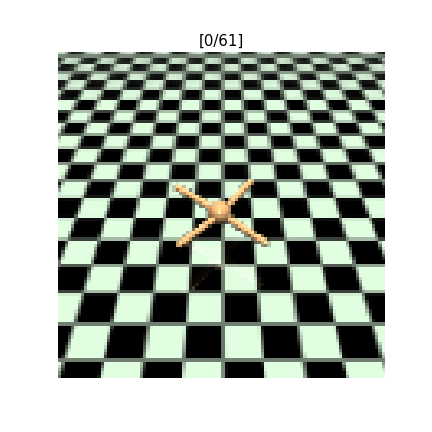
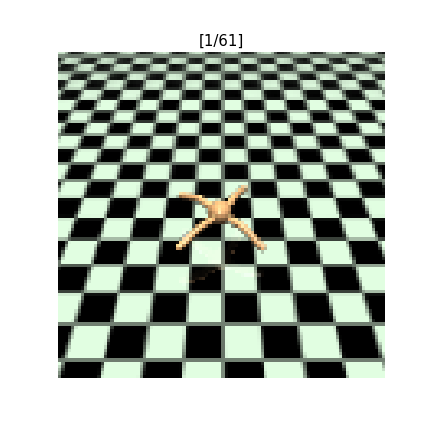
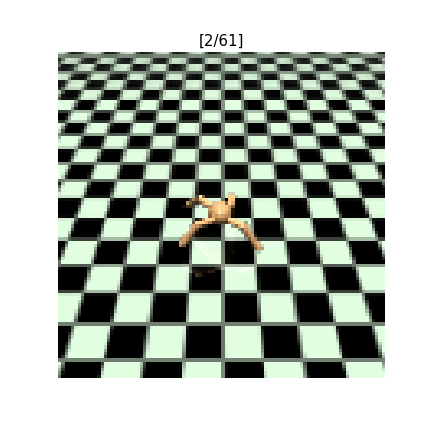
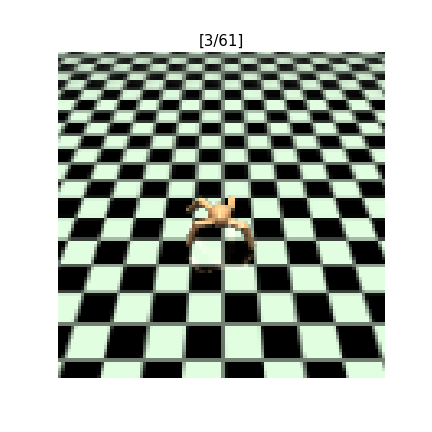
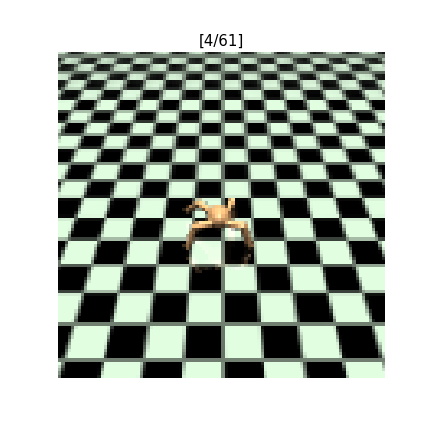
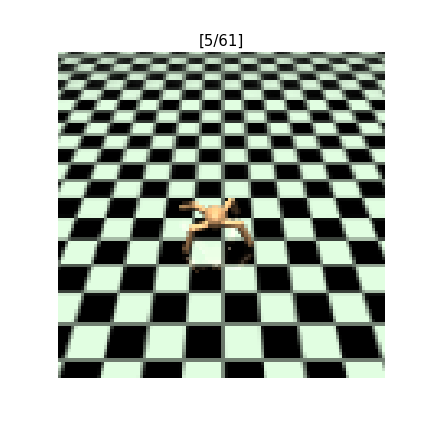
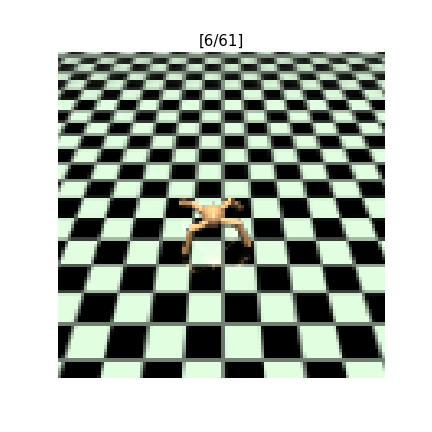
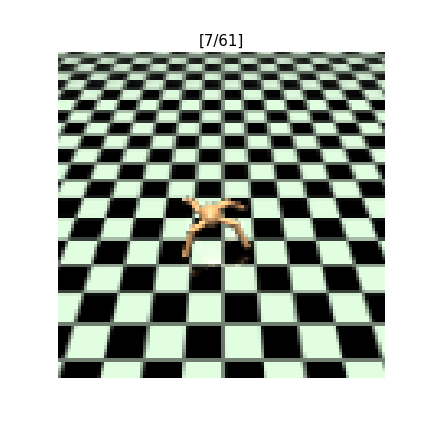
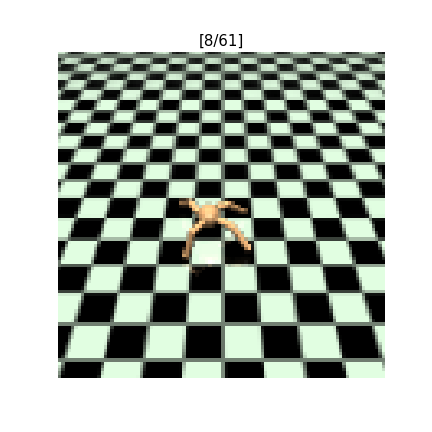
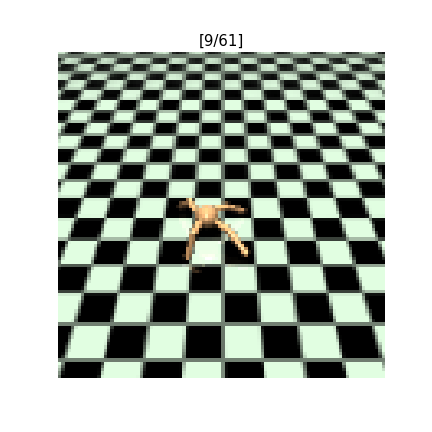
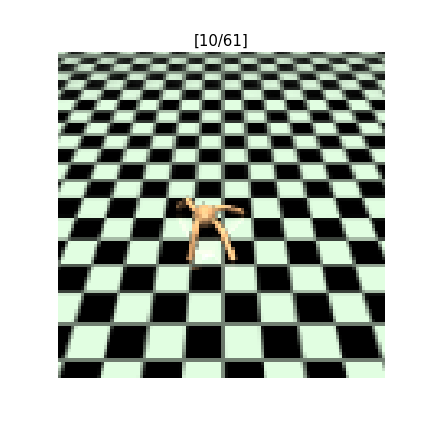
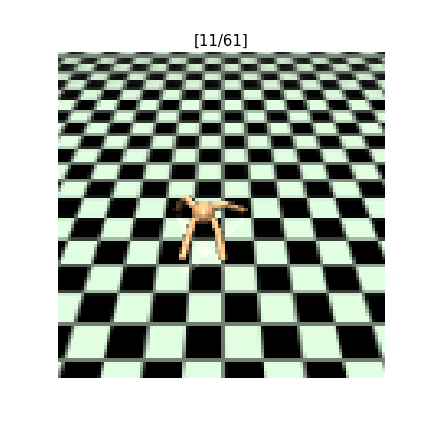
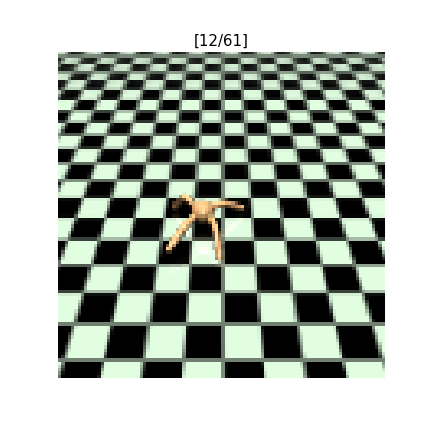
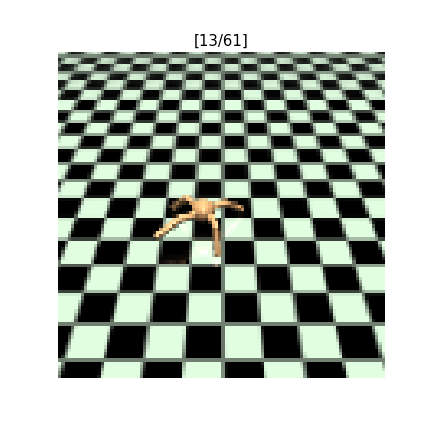
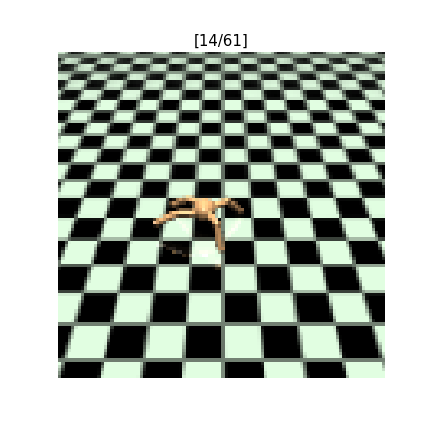
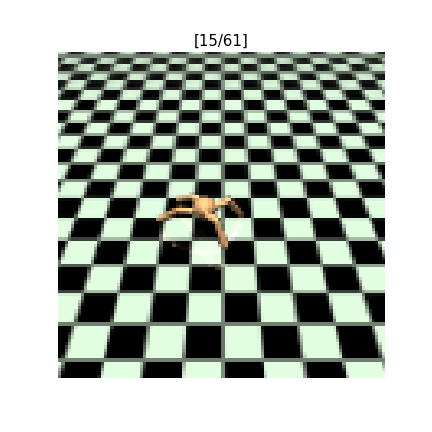
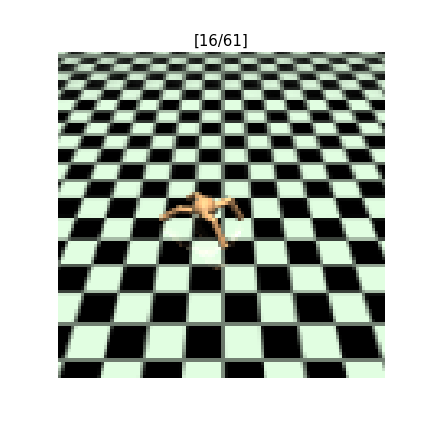
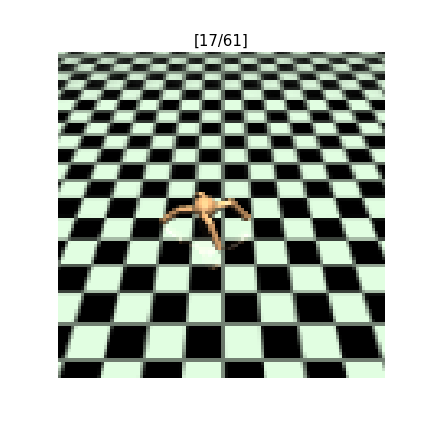
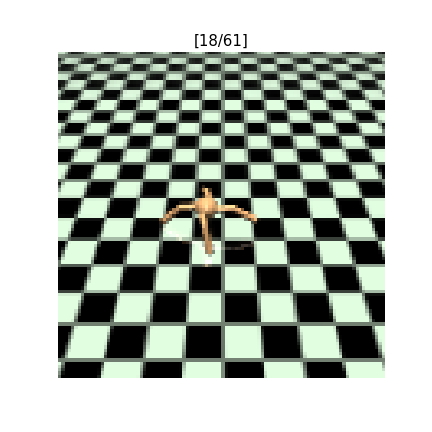
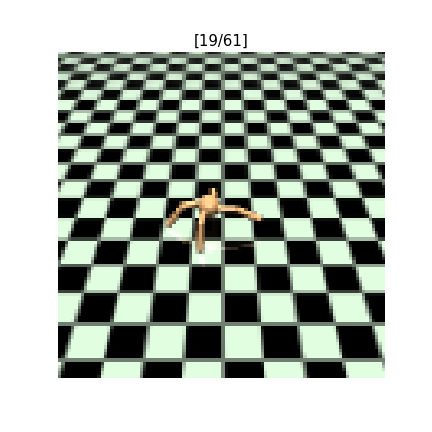
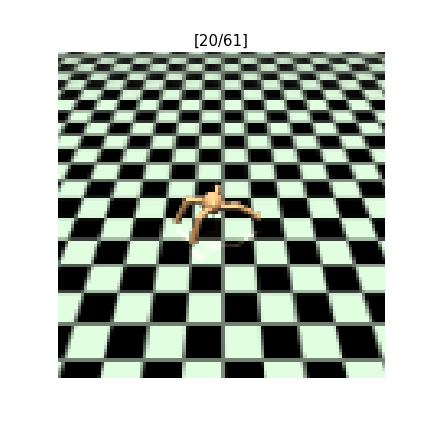
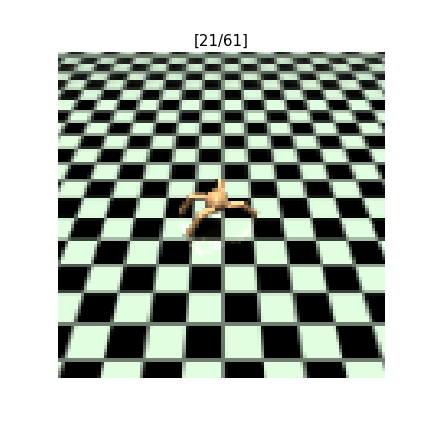
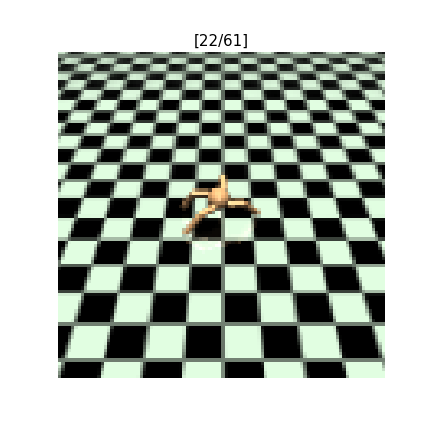
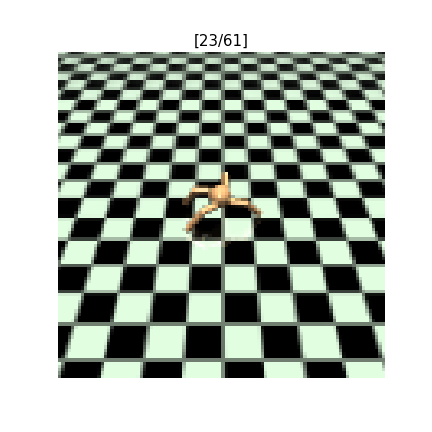
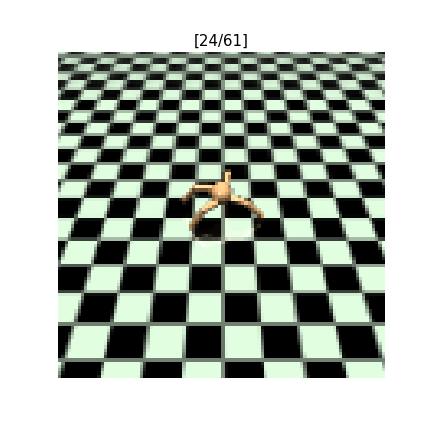
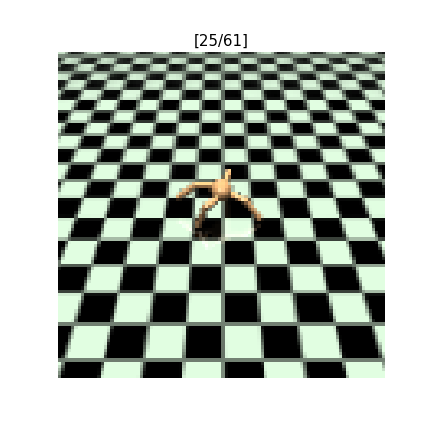
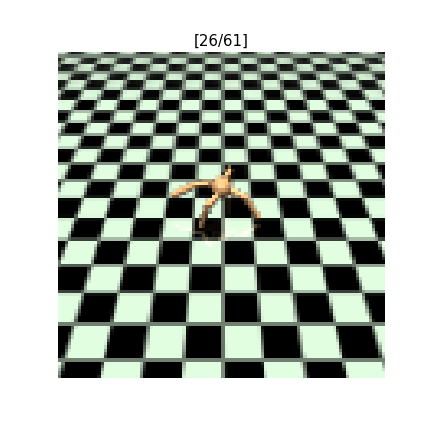
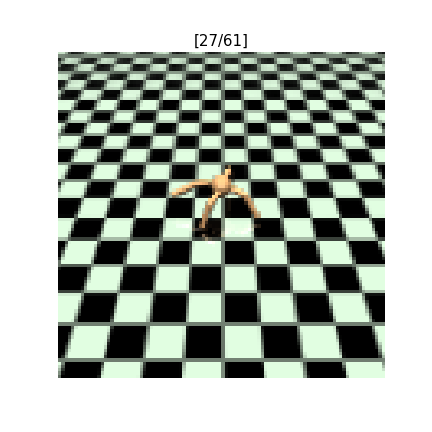
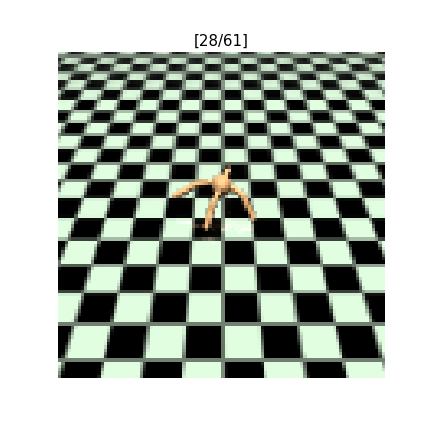
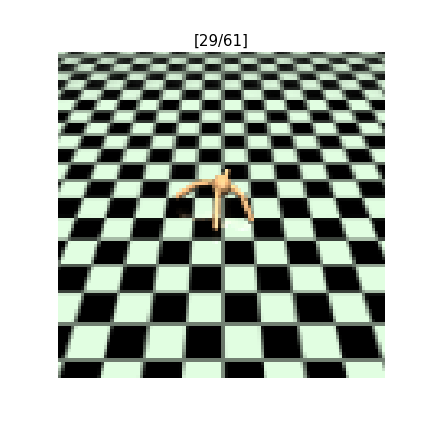
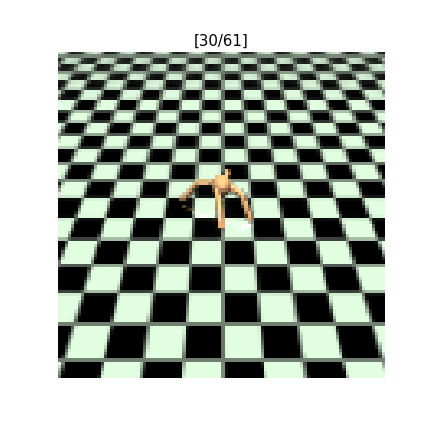
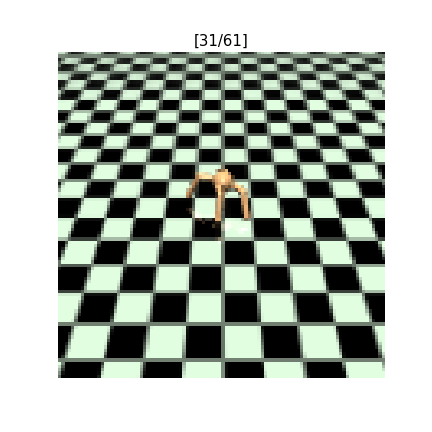
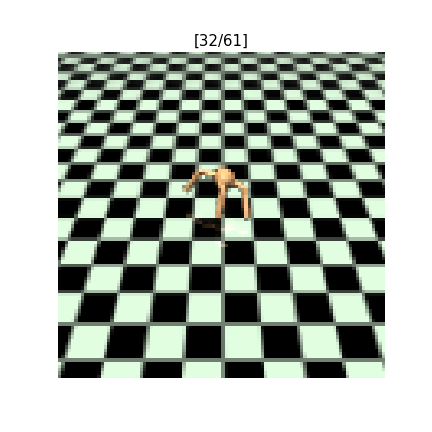
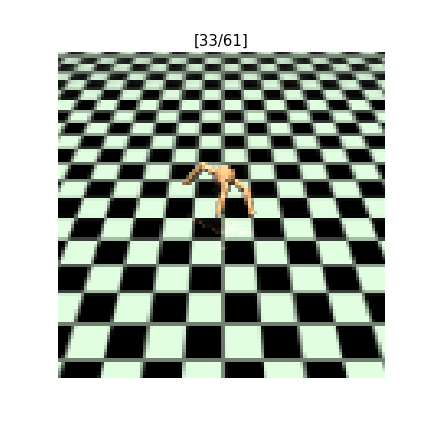
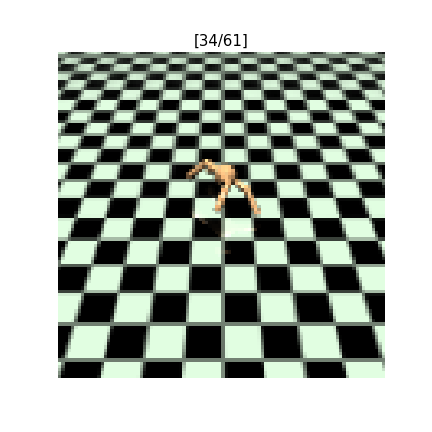
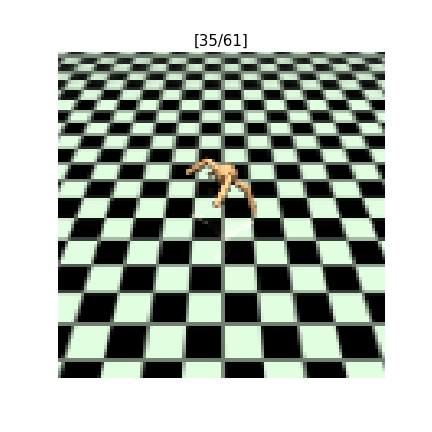
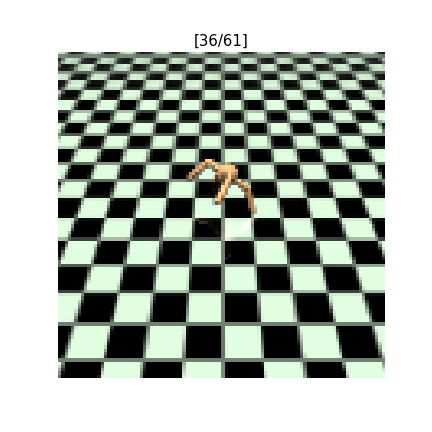
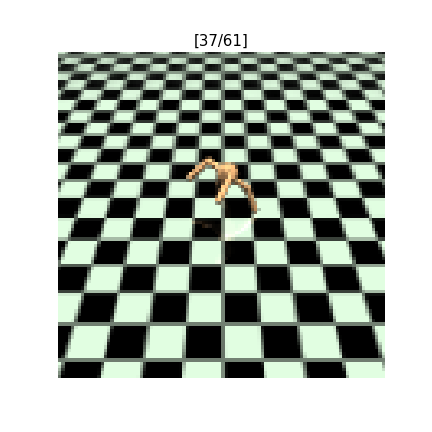
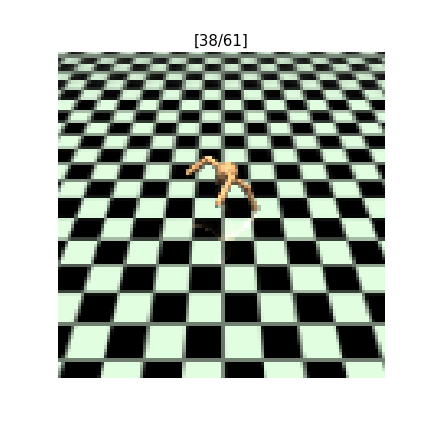
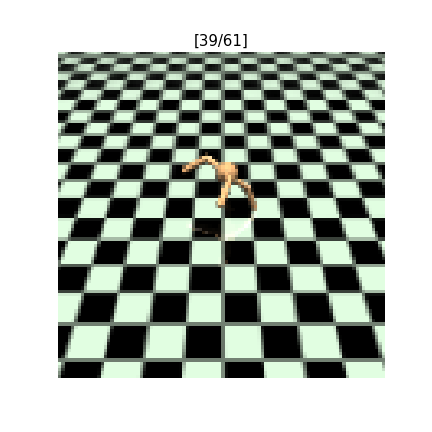
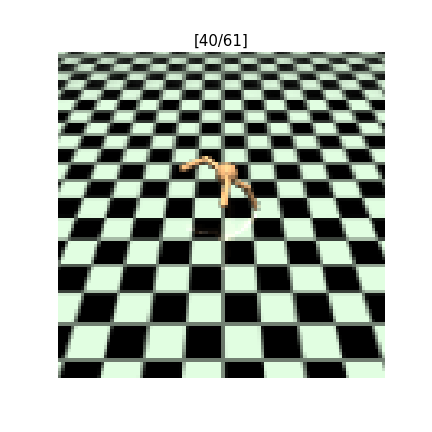
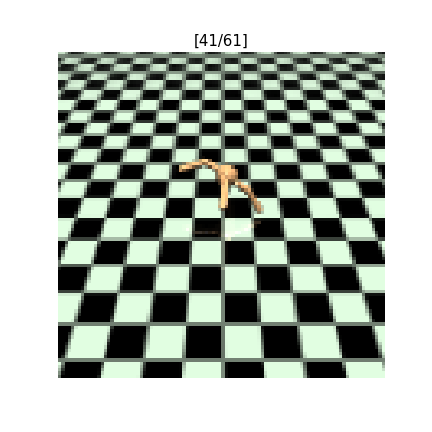
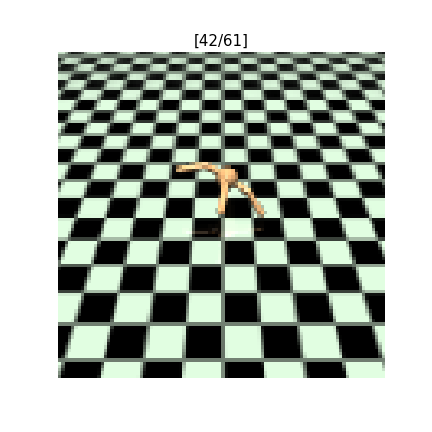
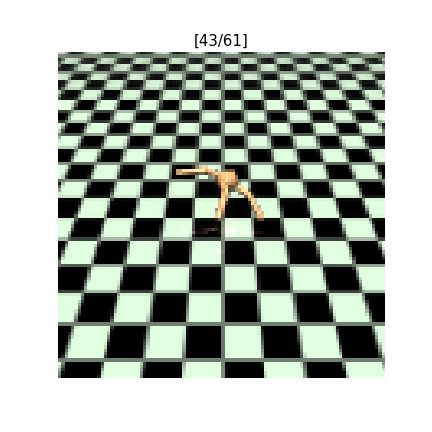
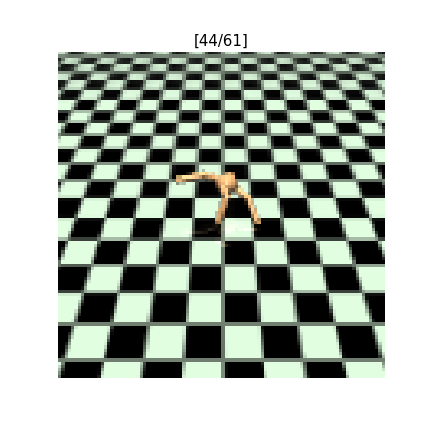
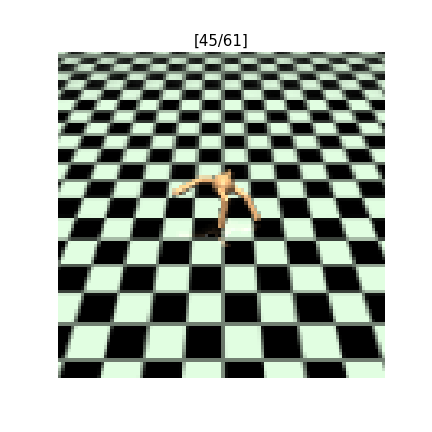
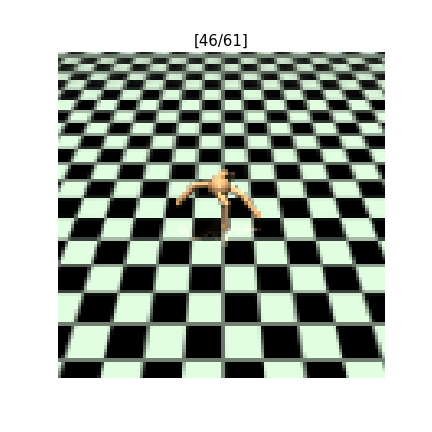
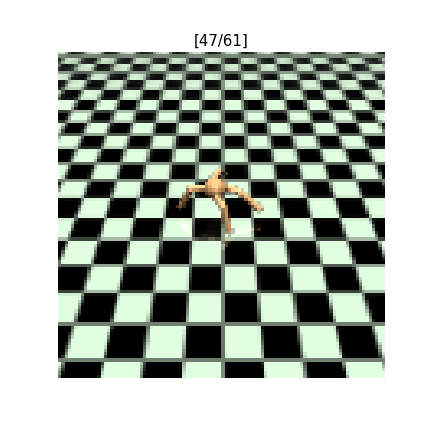
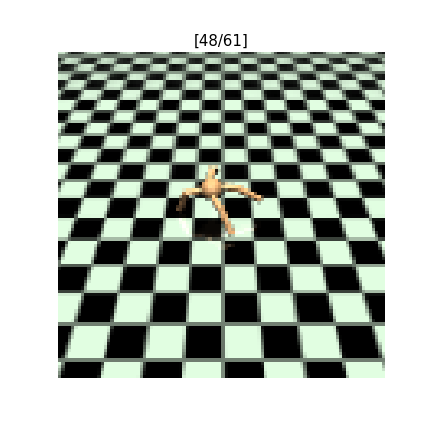
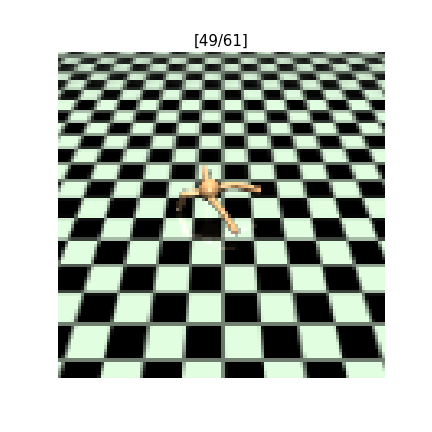
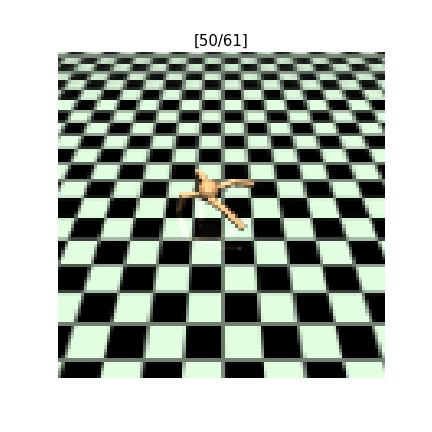
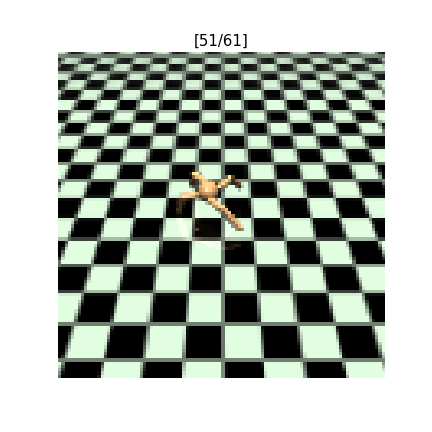
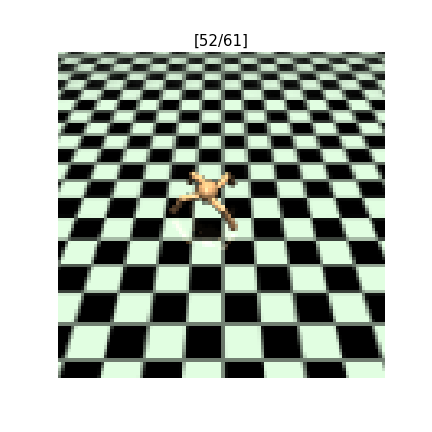
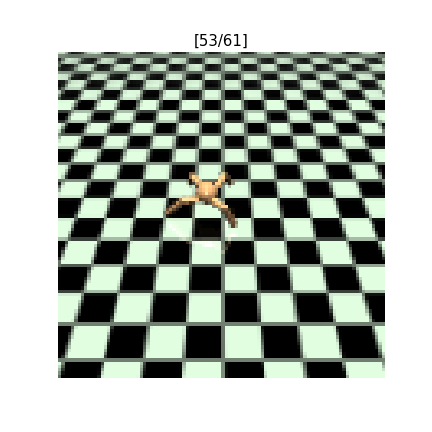
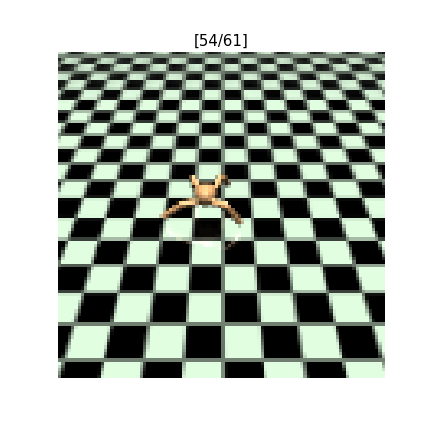
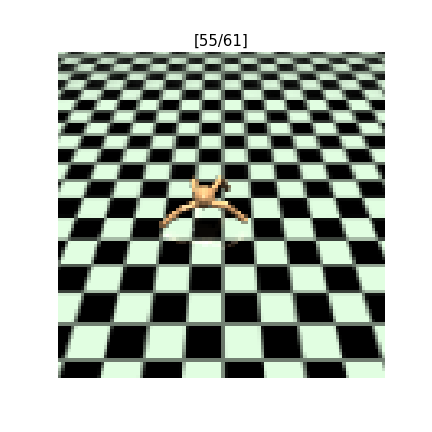
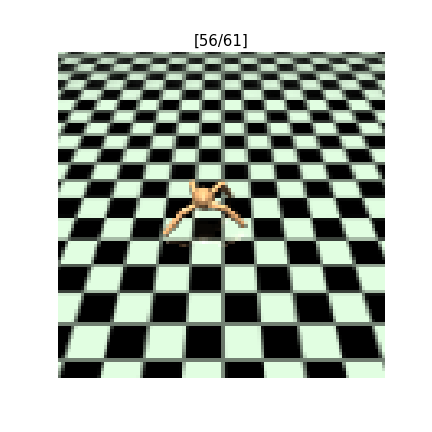
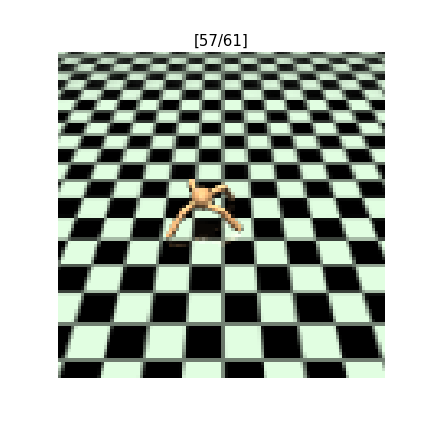
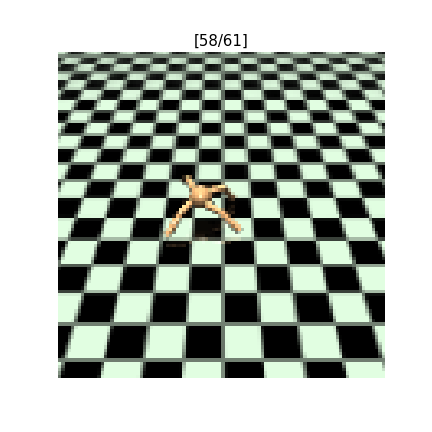
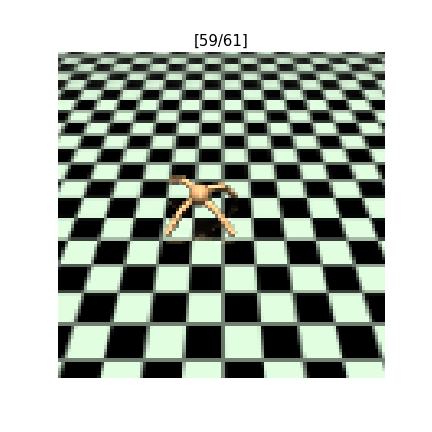
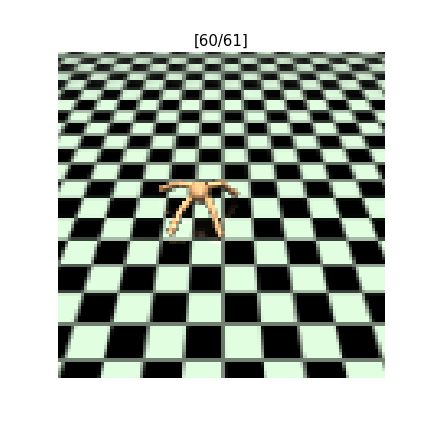

[vids/ant_ppo_init_0.mp4] saved.
Total reward: [-90.43132]



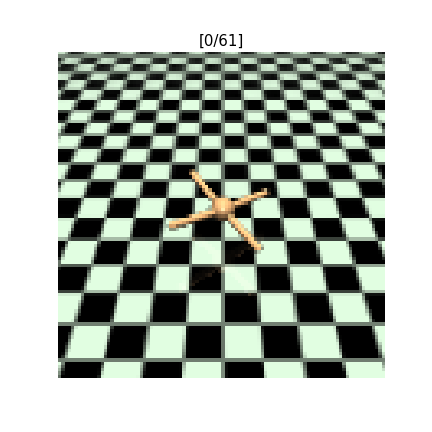
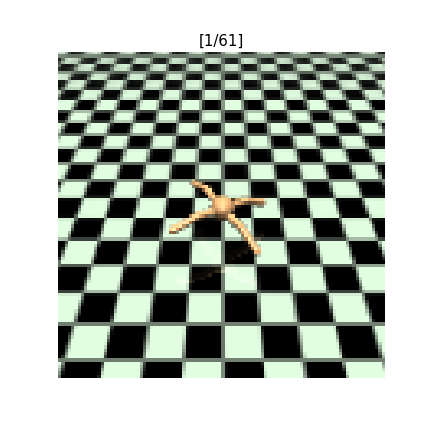
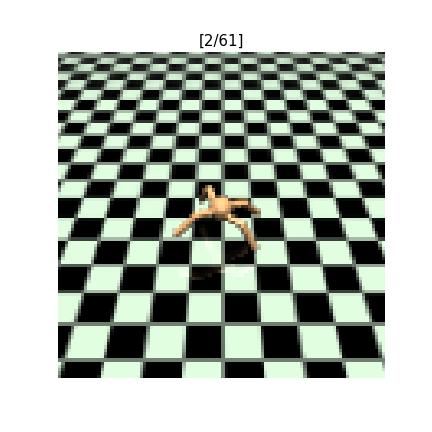
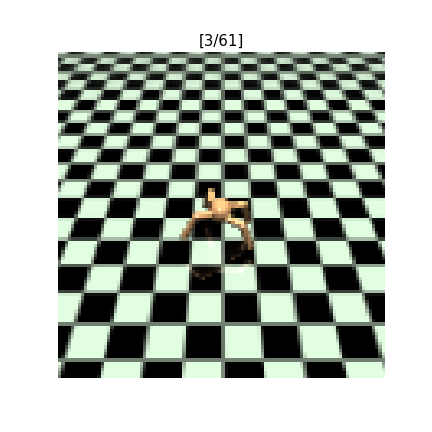
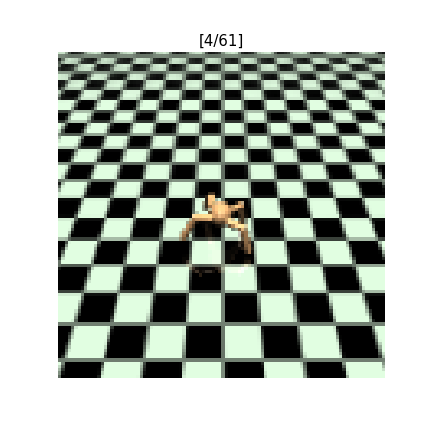
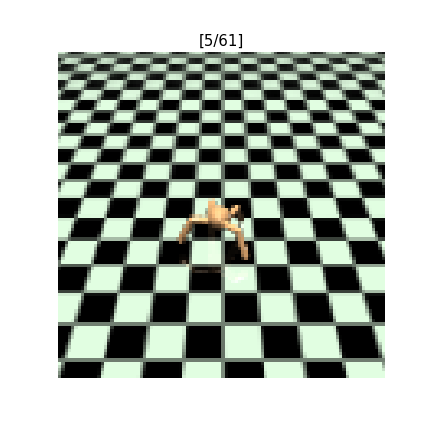
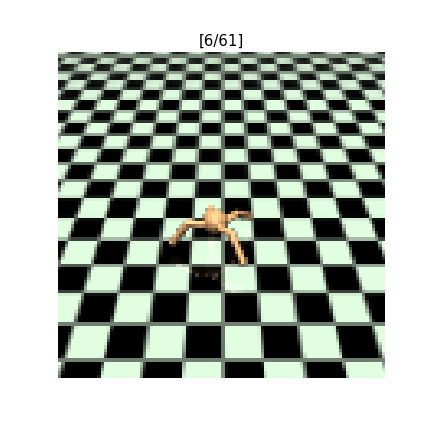
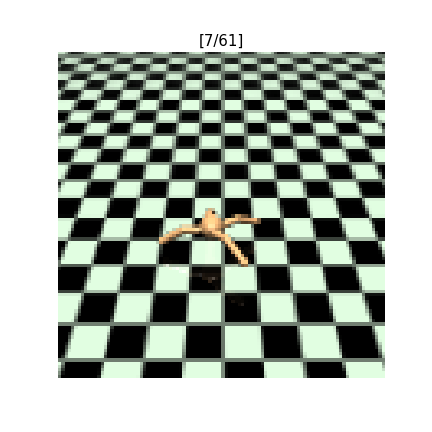
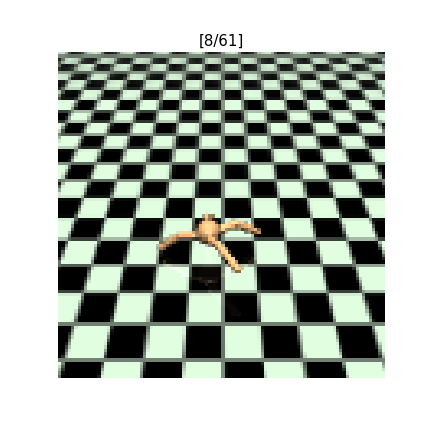
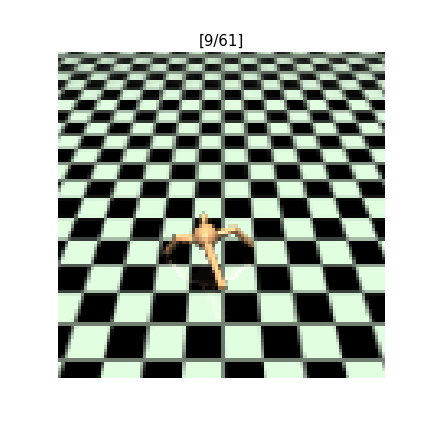
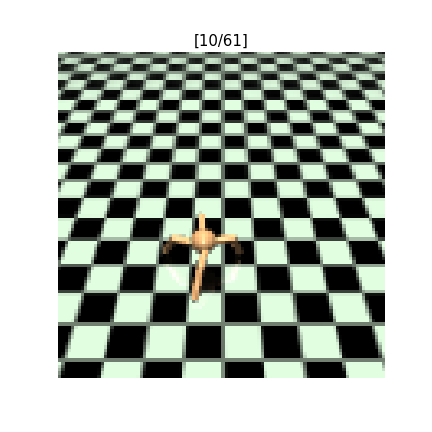
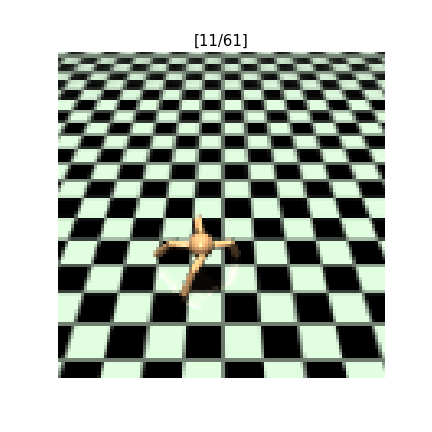
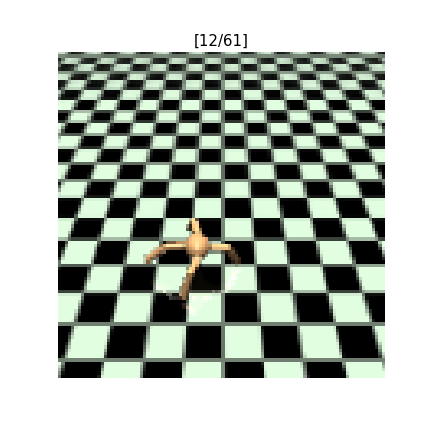
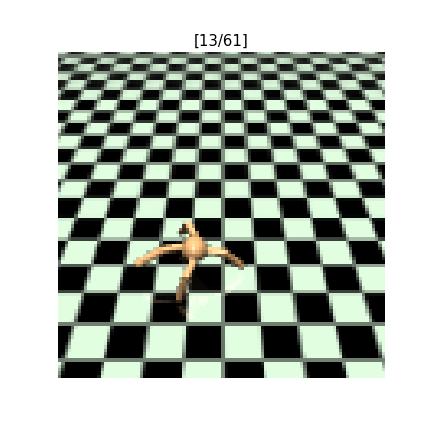
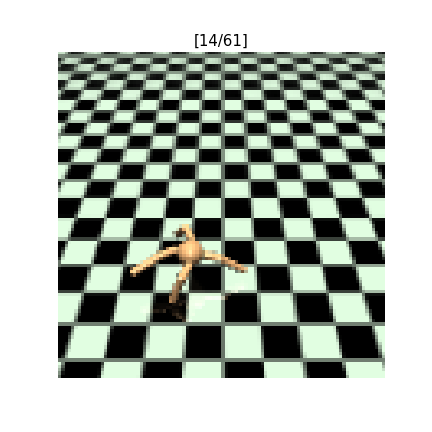
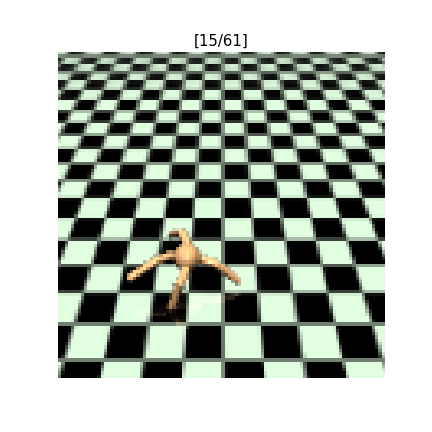
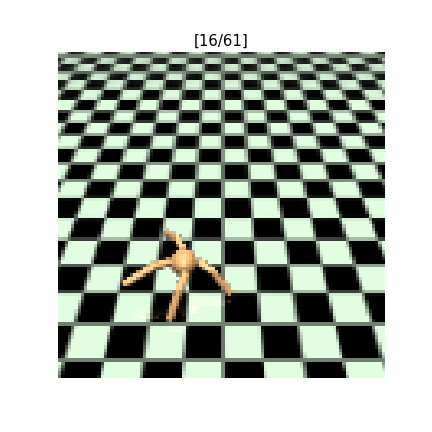
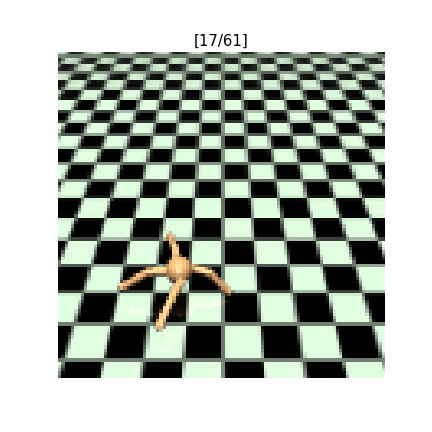
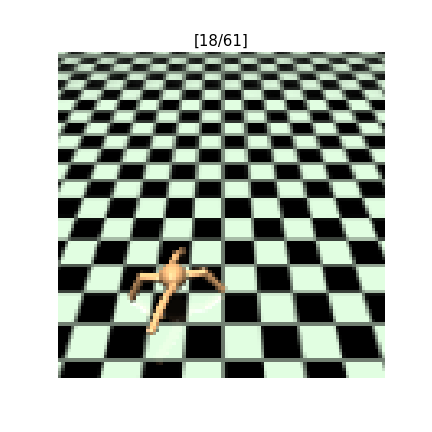
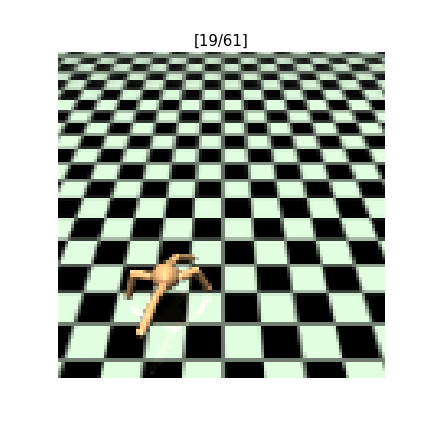
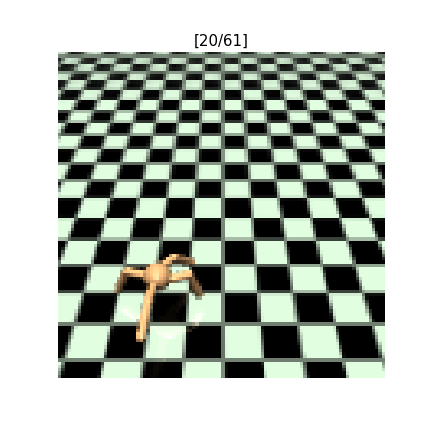
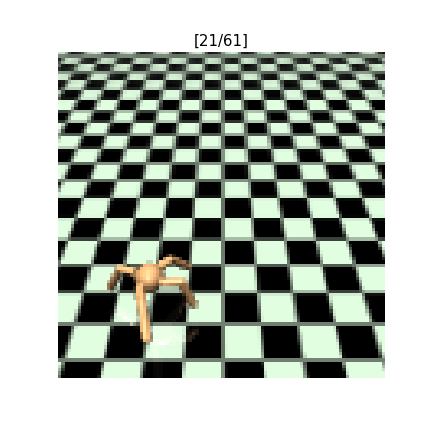
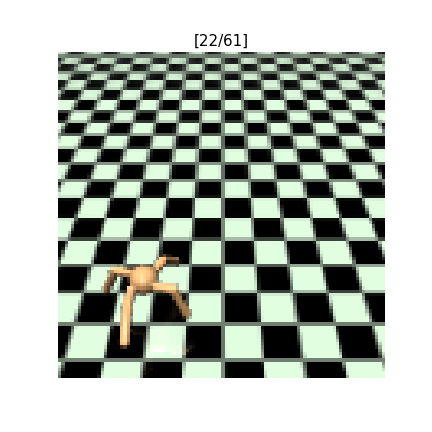
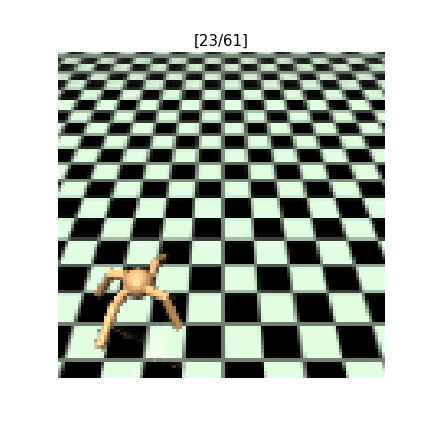
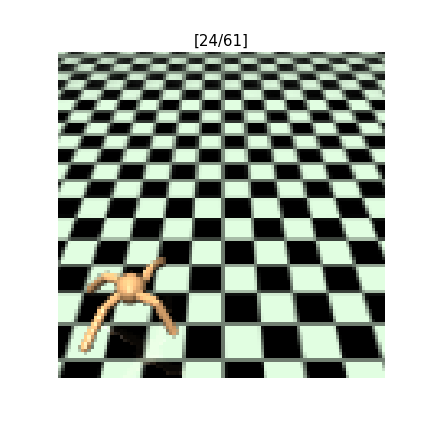
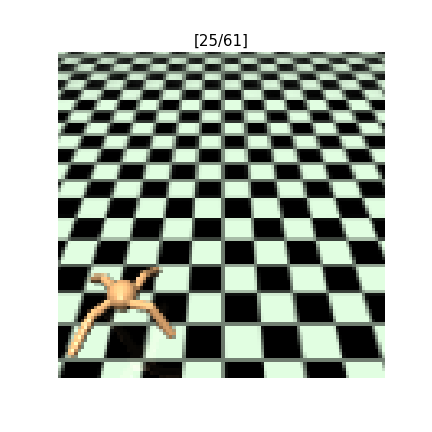
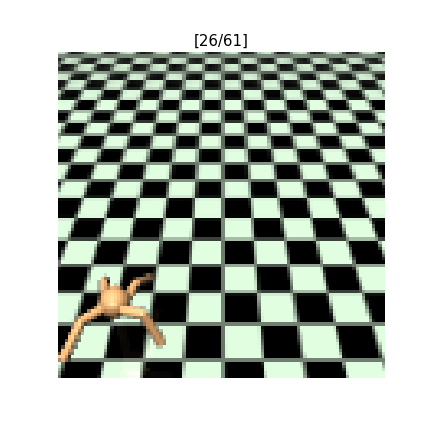
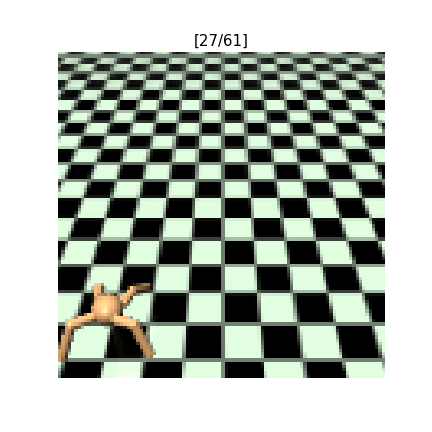
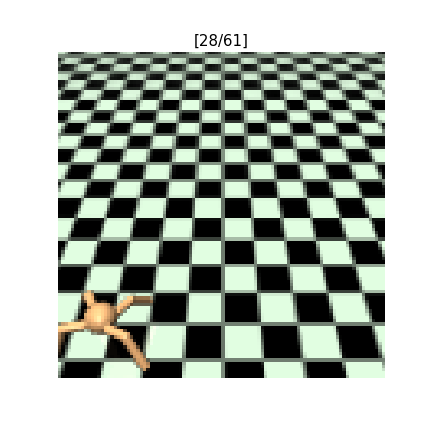
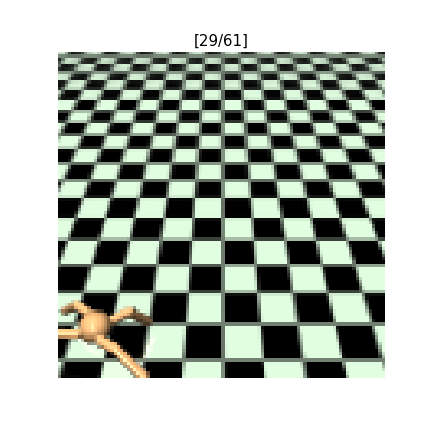
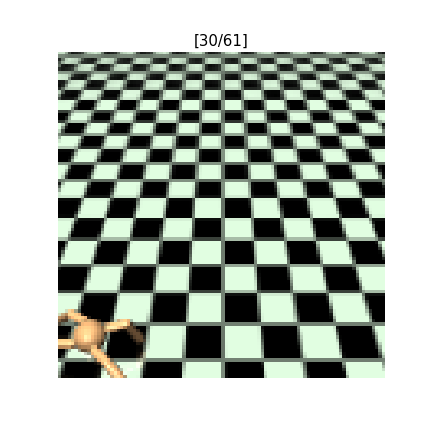
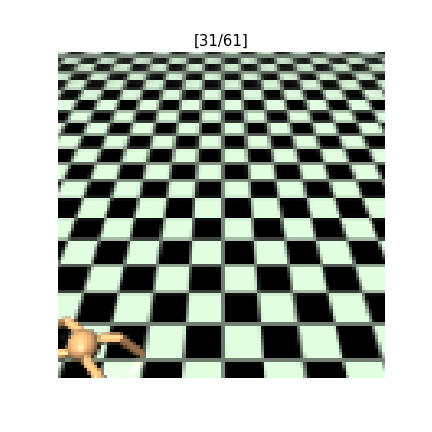
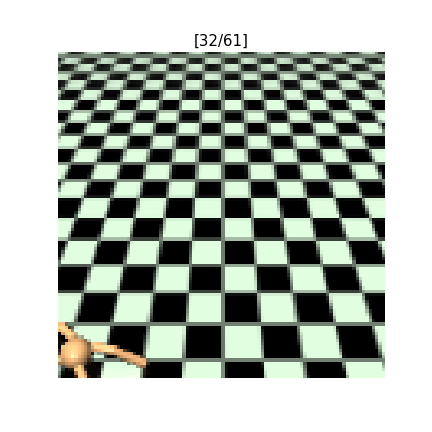
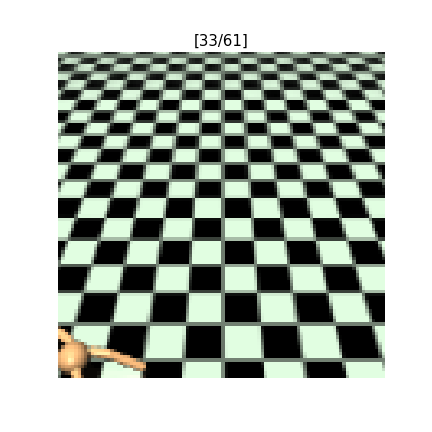
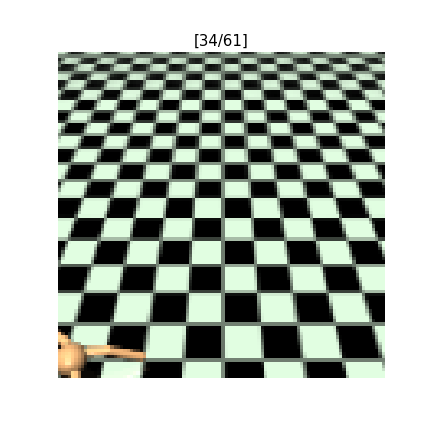
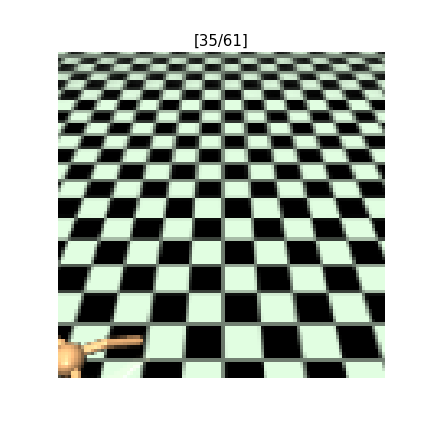
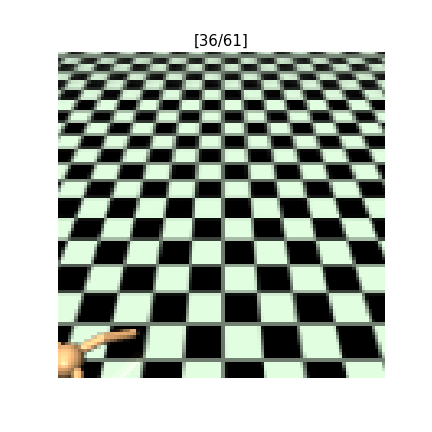
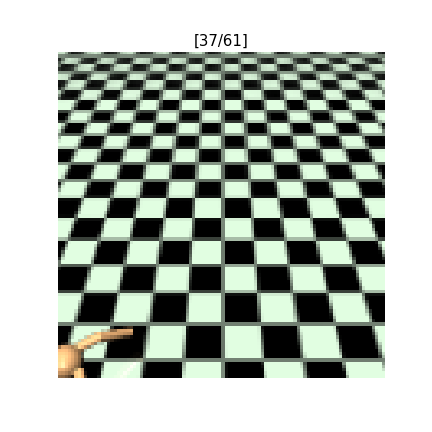
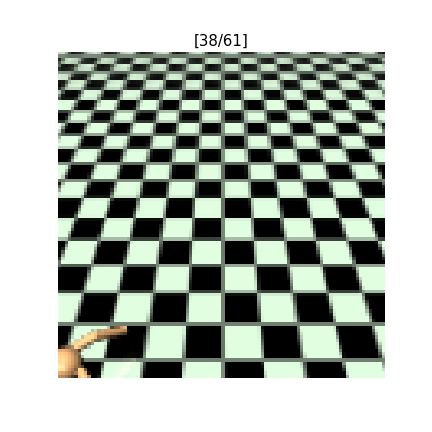
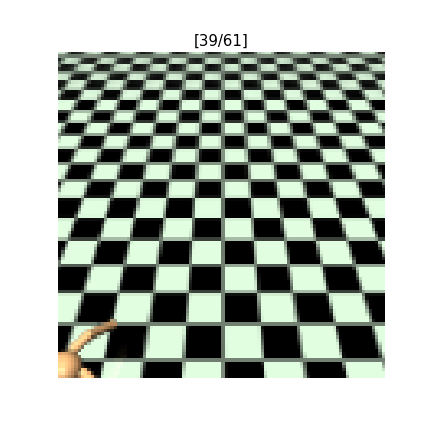
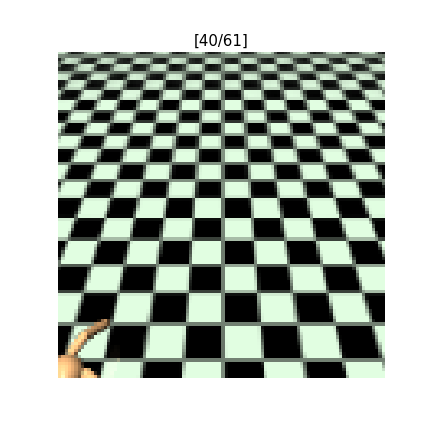
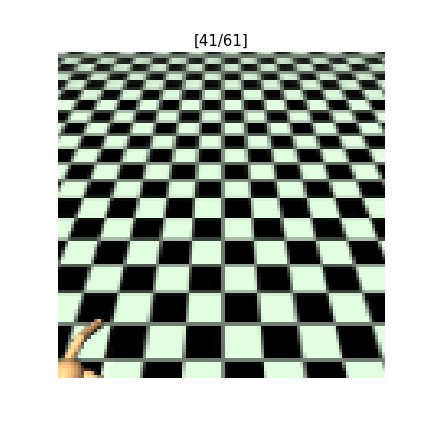
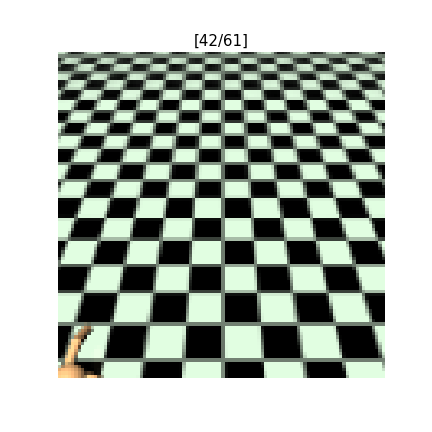
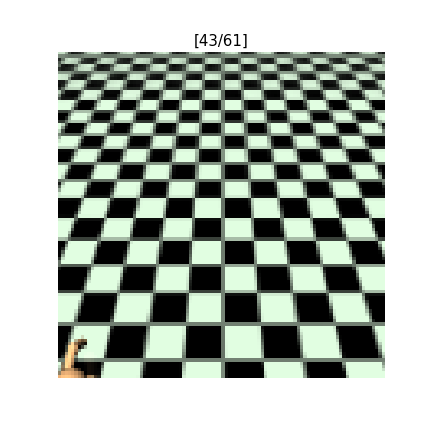
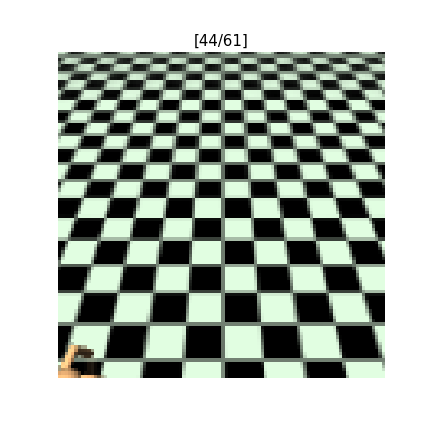
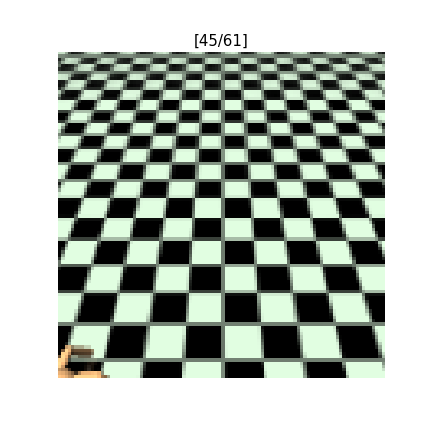
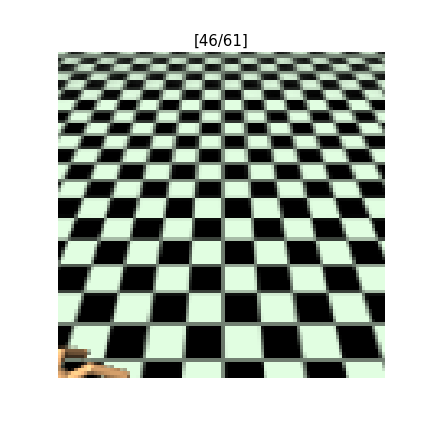
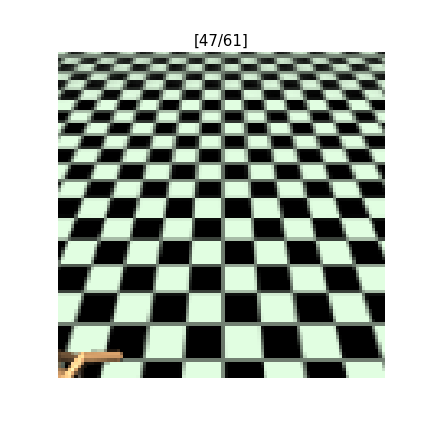
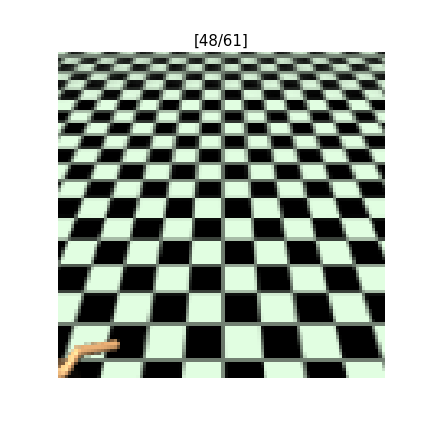
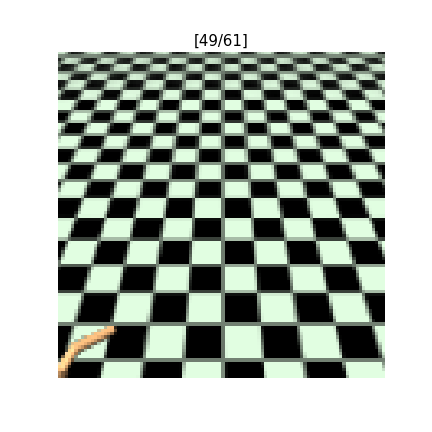
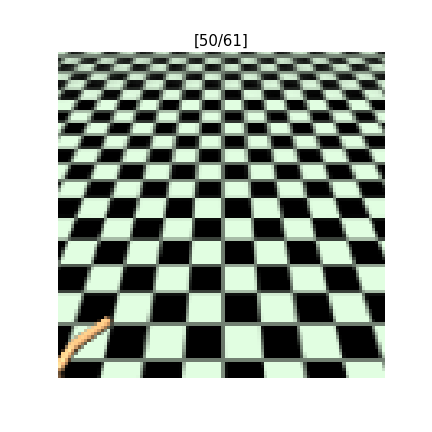
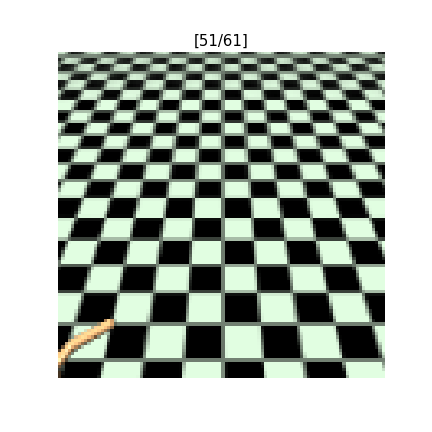
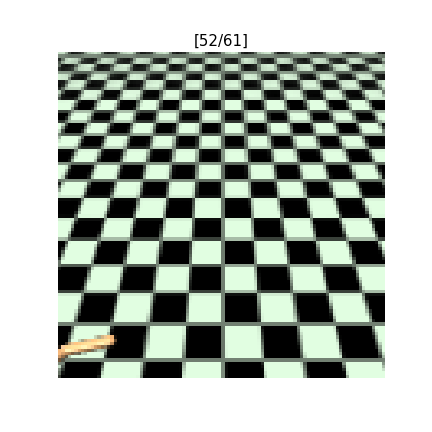
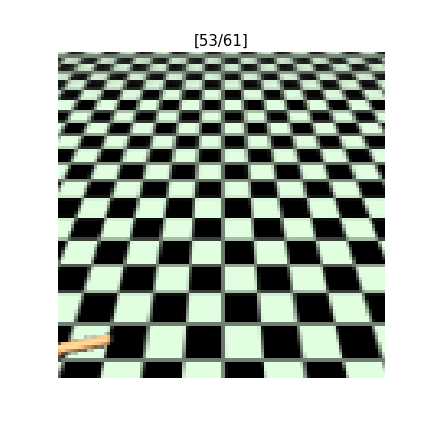
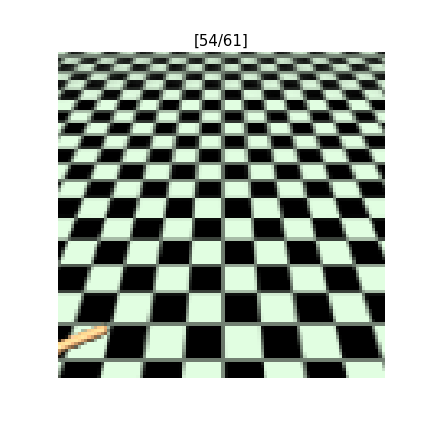
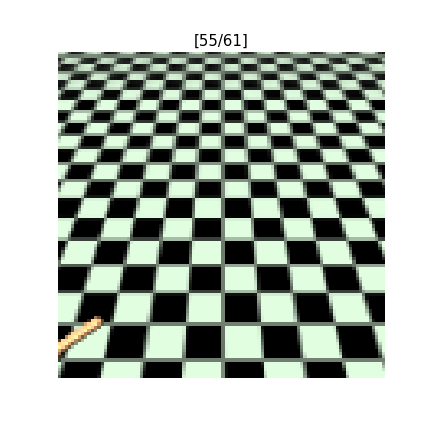
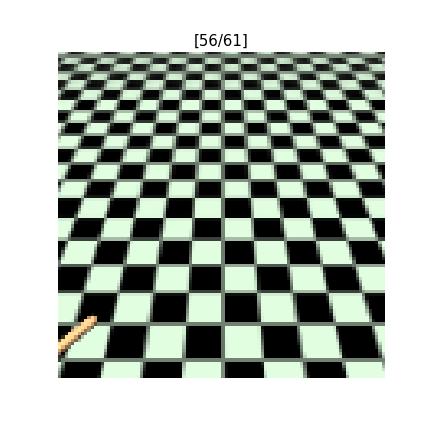
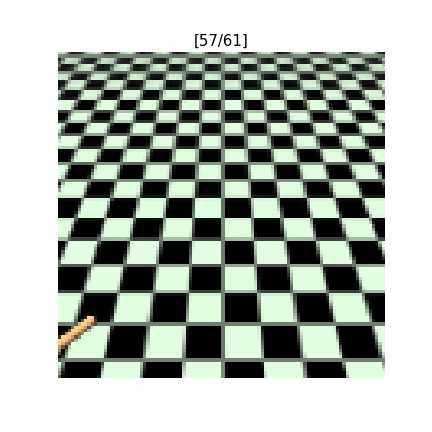
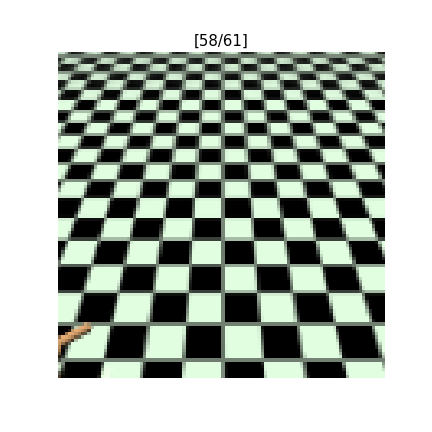
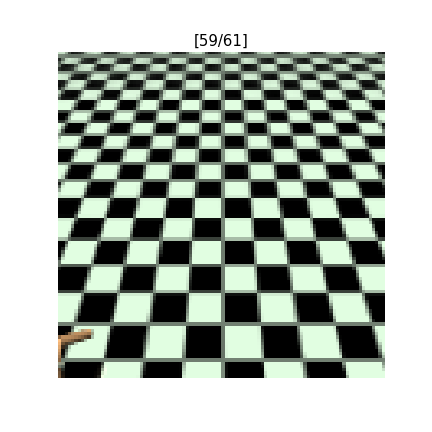
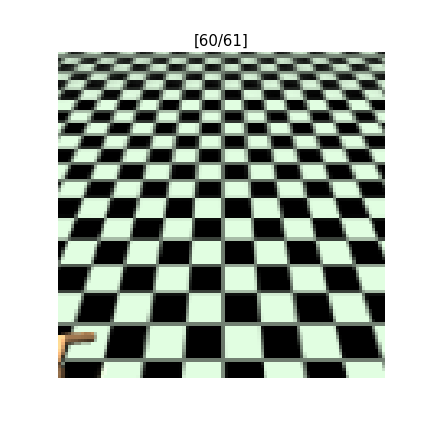

[vids/ant_ppo_init_1.mp4] saved.


In [17]:
import skvideo.io
for i in range(2):
    frames = run_episode_vid(env, policy, scaler)
    display_frames_as_gif(frames)
    outputdata = np.asarray(frames).astype(np.uint8)
    vidName = 'vids/ant_ppo_init_%d.mp4'%(i)
    skvideo.io.vwrite(vidName,outputdata, backend='ffmpeg')
    print ("[%s] saved."%(vidName))

### Loop

In [18]:
episode = 0
batch_size = 100 # How many episodes will we use per update. 
num_episodes = 10000 # Total number of episodes
episode4animate = 0
while episode < num_episodes:
    print ("Episode [%d/%d]"%(episode,num_episodes))
    # 1. Run policy
    trajectories = run_policy(env, policy, scaler, logger, episodes=batch_size)
    episode += len(trajectories)
    # 2. Get (predict) value from the critic network 
    add_value(trajectories, val_func)  # add estimated values to episodes
    # 3. Get GAE
    gamma = 0.995 # Discount factor 
    lam = 0.95 # Lambda for GAE
    add_disc_sum_rew(trajectories, gamma)  # calculated discounted sum of Rs
    add_gae(trajectories, gamma, lam)  # calculate advantage
    # concatenate all episodes into single NumPy arrays
    observes, actions, advantages, disc_sum_rew = build_train_set(trajectories)
    # add various stats to training log:
    log_batch_stats(observes, actions, advantages, disc_sum_rew, logger, episode)
    # Update
    policy.update(observes, actions, advantages, logger)  # update policy
    val_func.fit(observes, disc_sum_rew, logger)  # update value function
    logger.write(display=True)  # write logger results to file and stdout
    # Animate
    DO_ANIMATE = False
    if (episode>episode4animate) & (DO_ANIMATE):
        episode4animate += 5000 # Animate every 5000 episodes 
        frames = run_episode_vid(env, policy, scaler)
        display_frames_as_gif(frames)
print ("Done.")

Episode [0/10000]
***** Episode 100, Mean R = -48.5 *****
Beta: 1.5
ExplainedVarNew: 0.169
ExplainedVarOld: -1.86
KL: 0.0132
PolicyEntropy: 7.35
PolicyLoss: -0.04
Steps: 8.63e+03
ValFuncLoss: 0.0153


Episode [100/10000]
***** Episode 200, Mean R = -55.1 *****
Beta: 2.25
ExplainedVarNew: 0.147
ExplainedVarOld: -0.581
KL: 0.0106
PolicyEntropy: 7.34
PolicyLoss: -0.0275
Steps: 8.98e+03
ValFuncLoss: 0.0167


Episode [200/10000]
***** Episode 300, Mean R = -51.3 *****
Beta: 3.38
ExplainedVarNew: 0.206
ExplainedVarOld: 0.0243
KL: 0.0148
PolicyEntropy: 7.3
PolicyLoss: -0.181
Steps: 8.39e+03
ValFuncLoss: 0.0143


Episode [300/10000]
***** Episode 400, Mean R = -57.7 *****
Beta: 3.38
ExplainedVarNew: 0.142
ExplainedVarOld: 0.039
KL: 0.00385
PolicyEntropy: 7.26
PolicyLoss: -0.00952
Steps: 9.19e+03
ValFuncLoss: 0.0214


Episode [400/10000]
***** Episode 500, Mean R = -49.8 *****
Beta: 5.06
ExplainedVarNew: 0.262
ExplainedVarOld: 0.163
KL: 0.00661
PolicyEntropy: 7.24
PolicyLoss: -0.092
Steps: 8.68

***** Episode 4100, Mean R = -19.2 *****
Beta: 3.38
ExplainedVarNew: 0.218
ExplainedVarOld: 0.00119
KL: 0.00329
PolicyEntropy: 6.29
PolicyLoss: -0.0149
Steps: 8.5e+03
ValFuncLoss: 0.00957


Episode [4100/10000]
***** Episode 4200, Mean R = -22.4 *****
Beta: 3.38
ExplainedVarNew: 0.208
ExplainedVarOld: -0.00467
KL: 0.0029
PolicyEntropy: 6.27
PolicyLoss: -0.0123
Steps: 8.67e+03
ValFuncLoss: 0.00896


Episode [4200/10000]
***** Episode 4300, Mean R = -15.8 *****
Beta: 3.38
ExplainedVarNew: 0.237
ExplainedVarOld: 0.0351
KL: 0.00327
PolicyEntropy: 6.23
PolicyLoss: -0.0143
Steps: 8.3e+03
ValFuncLoss: 0.00882


Episode [4300/10000]
***** Episode 4400, Mean R = -11.4 *****
Beta: 3.38
ExplainedVarNew: 0.178
ExplainedVarOld: -0.00855
KL: 0.00348
PolicyEntropy: 6.2
PolicyLoss: -0.0151
Steps: 7.23e+03
ValFuncLoss: 0.0105


Episode [4400/10000]
***** Episode 4500, Mean R = -10.7 *****
Beta: 3.38
ExplainedVarNew: 0.243
ExplainedVarOld: -0.000574
KL: 0.00491
PolicyEntropy: 6.17
PolicyLoss: -0.0211
St

***** Episode 8100, Mean R = 7.7 *****
Beta: 3.38
ExplainedVarNew: 0.249
ExplainedVarOld: 0.12
KL: 0.00231
PolicyEntropy: 5.28
PolicyLoss: -0.00887
Steps: 9.78e+03
ValFuncLoss: 0.00795


Episode [8100/10000]
***** Episode 8200, Mean R = 6.5 *****
Beta: 3.38
ExplainedVarNew: 0.242
ExplainedVarOld: 0.0952
KL: 0.00259
PolicyEntropy: 5.25
PolicyLoss: -0.0107
Steps: 8.98e+03
ValFuncLoss: 0.0095


Episode [8200/10000]
***** Episode 8300, Mean R = 5.7 *****
Beta: 3.38
ExplainedVarNew: 0.205
ExplainedVarOld: 0.0504
KL: 0.00217
PolicyEntropy: 5.23
PolicyLoss: -0.00888
Steps: 8.65e+03
ValFuncLoss: 0.00791


Episode [8300/10000]
***** Episode 8400, Mean R = 4.9 *****
Beta: 3.38
ExplainedVarNew: 0.267
ExplainedVarOld: 0.117
KL: 0.00293
PolicyEntropy: 5.2
PolicyLoss: -0.0115
Steps: 8.28e+03
ValFuncLoss: 0.00705


Episode [8400/10000]
***** Episode 8500, Mean R = 4.9 *****
Beta: 3.38
ExplainedVarNew: 0.263
ExplainedVarOld: 0.116
KL: 0.00268
PolicyEntropy: 5.18
PolicyLoss: -0.0095
Steps: 9.47e+03
Val

### Animate final motion

Total reward: [25.75307]



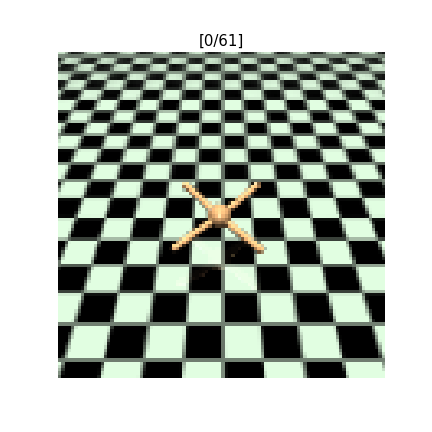
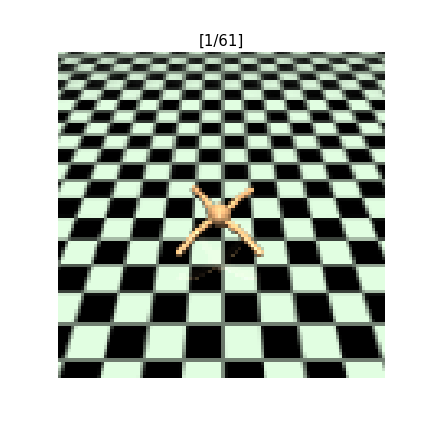
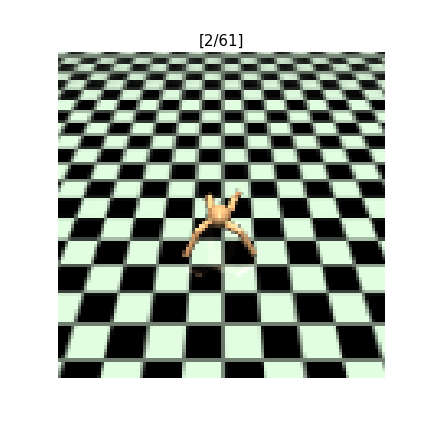
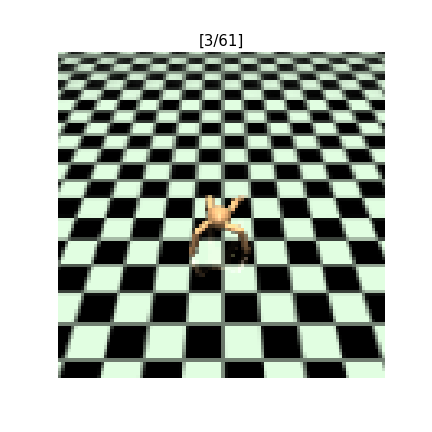
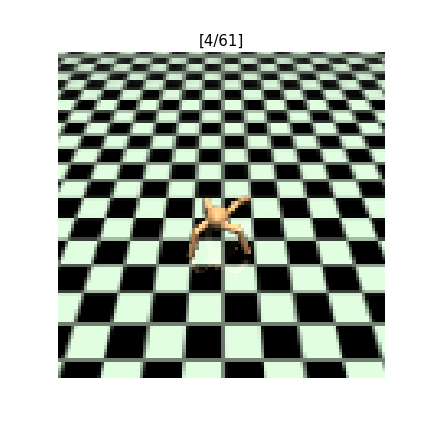
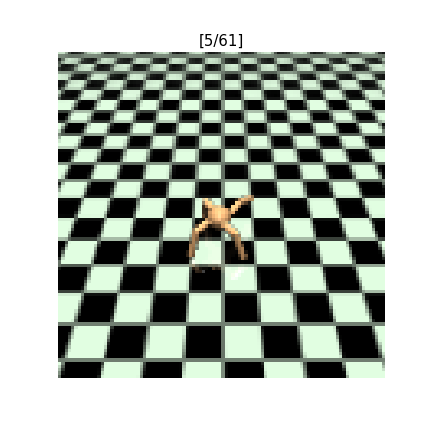
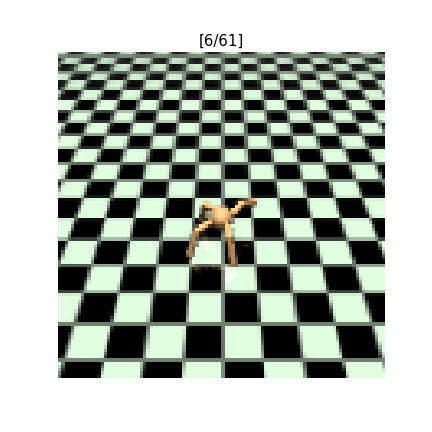
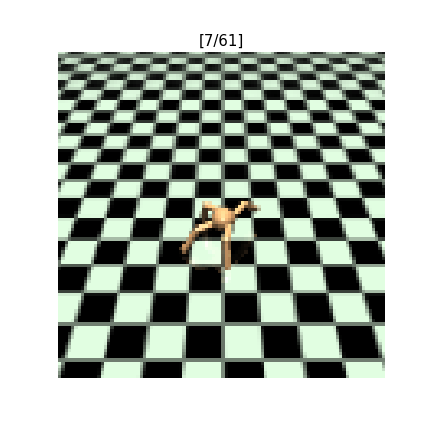
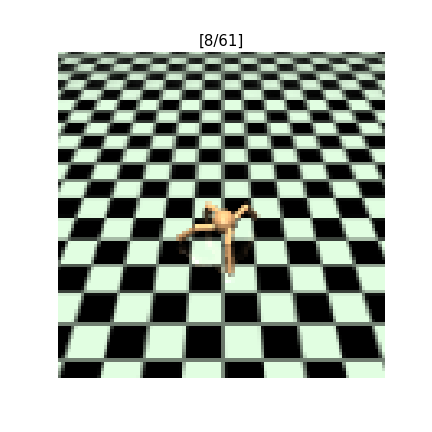
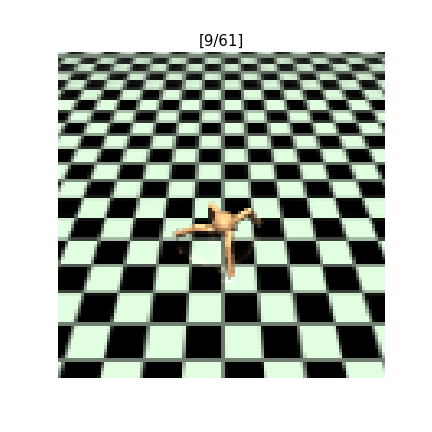
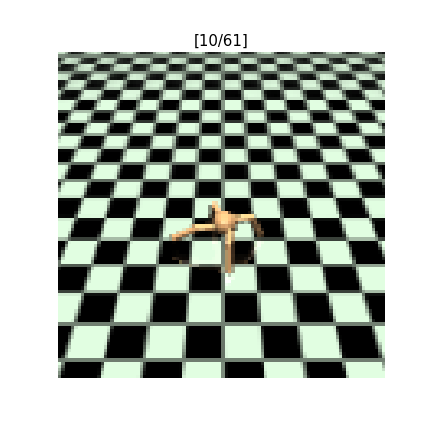
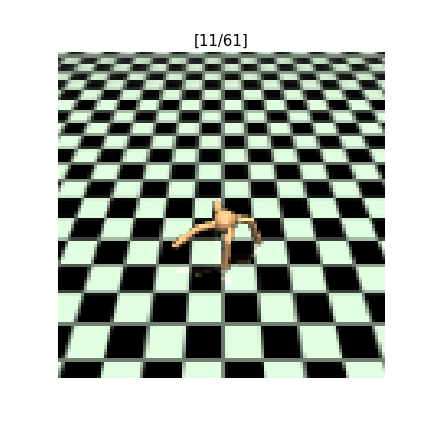
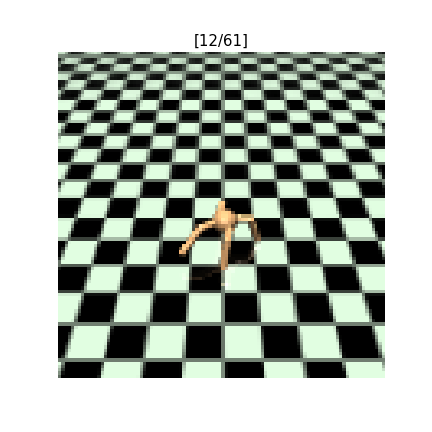
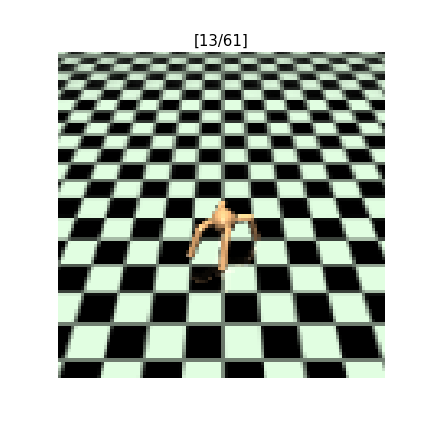
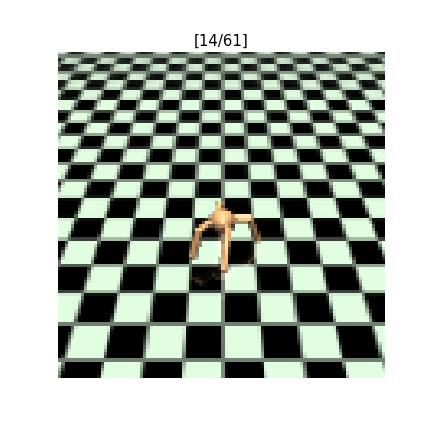
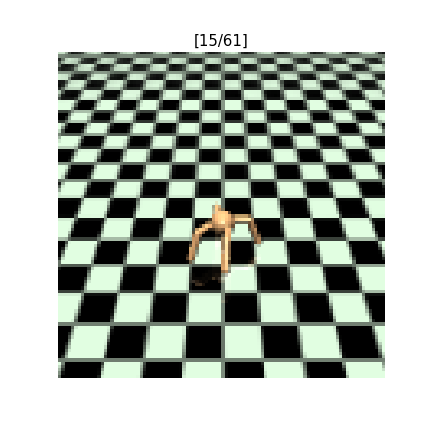
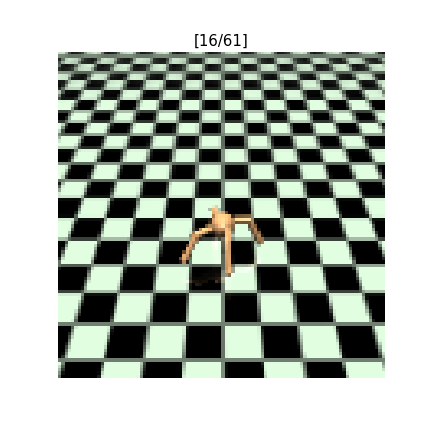
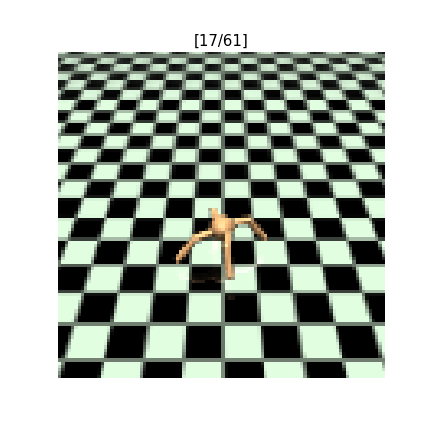
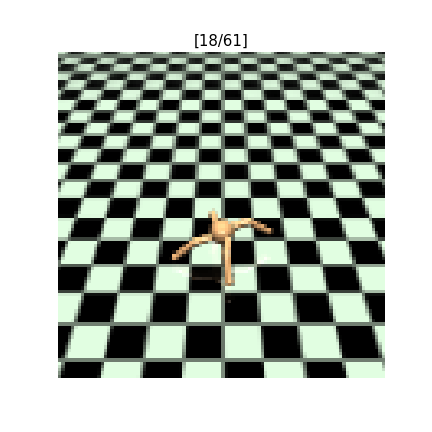
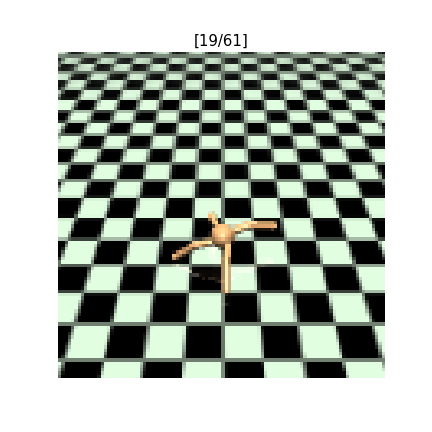
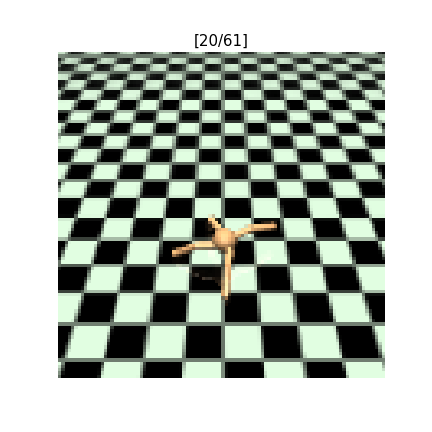
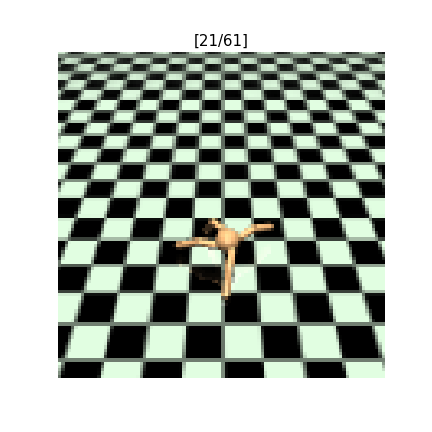
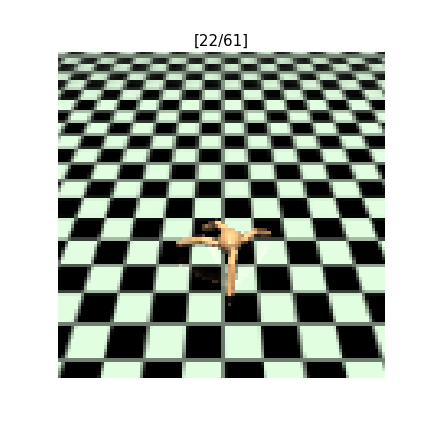
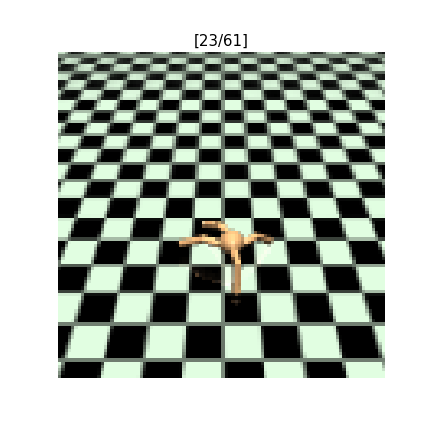
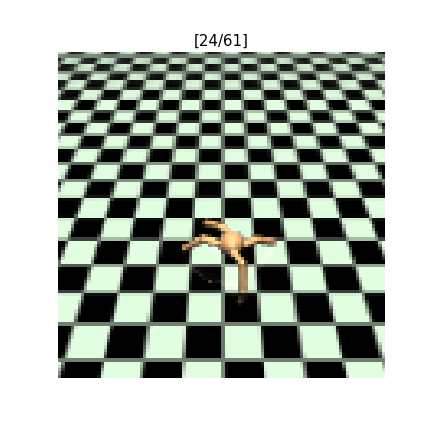
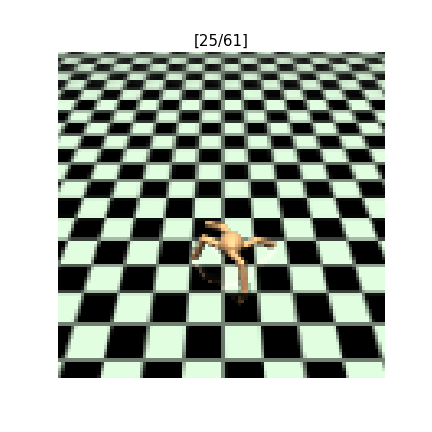
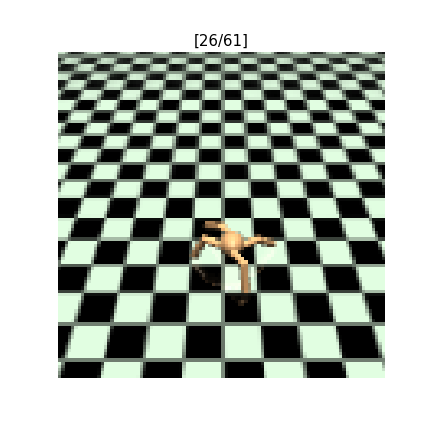
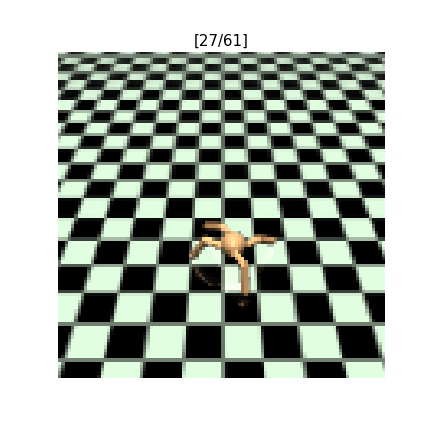
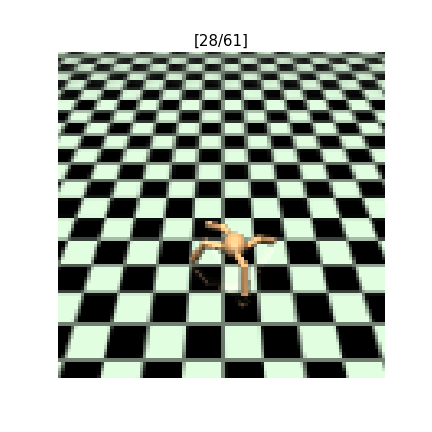
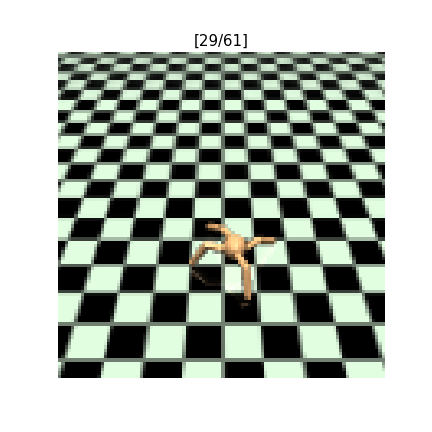
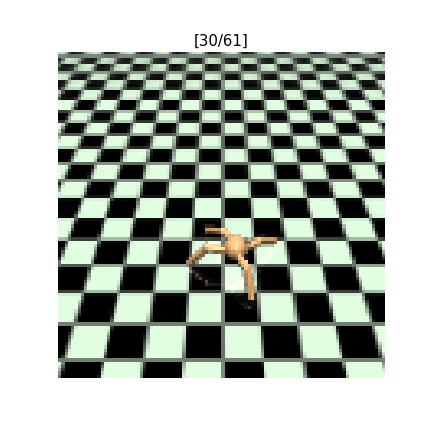
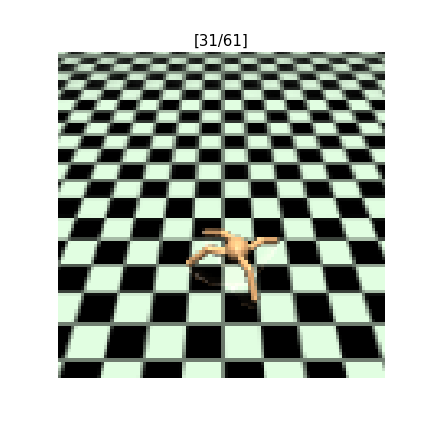
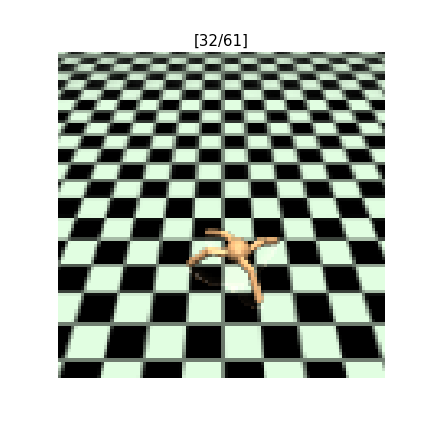
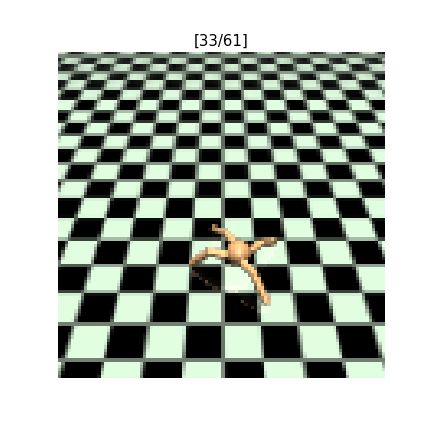
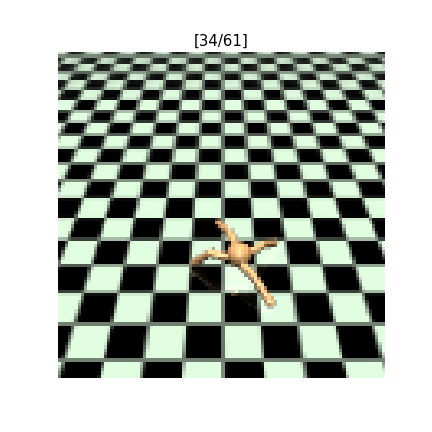
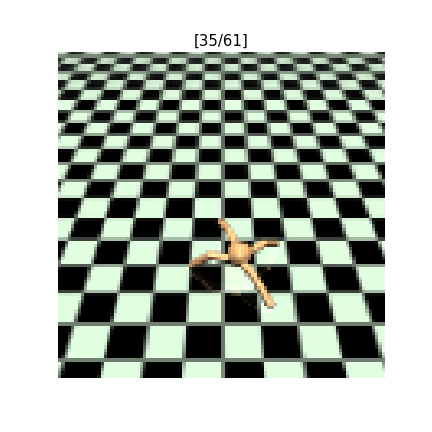
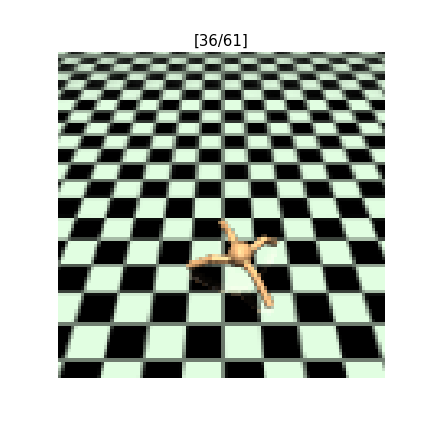
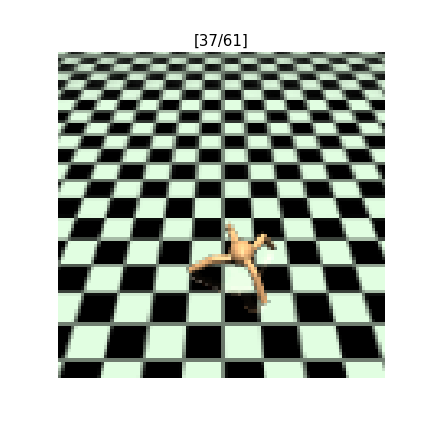
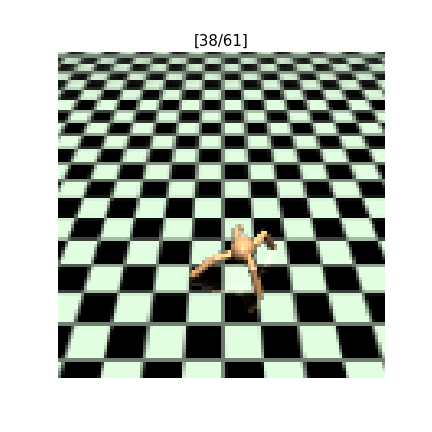
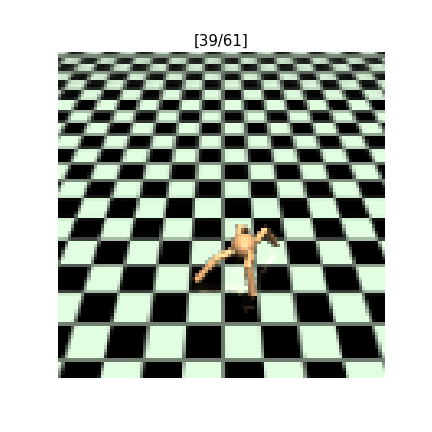
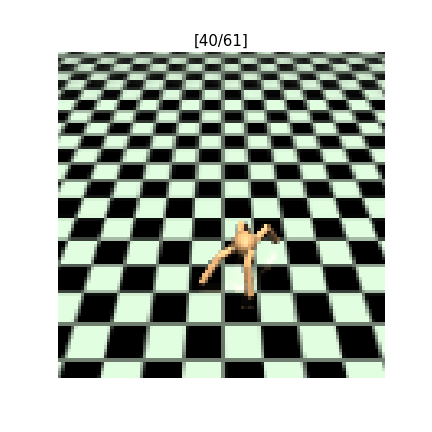
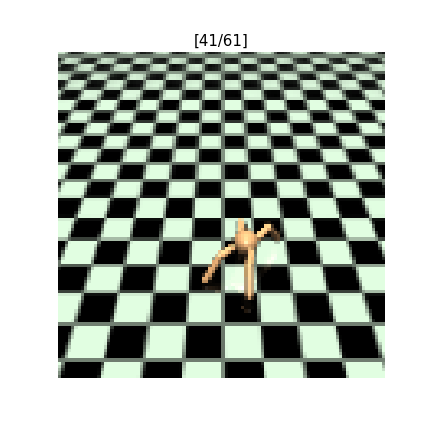
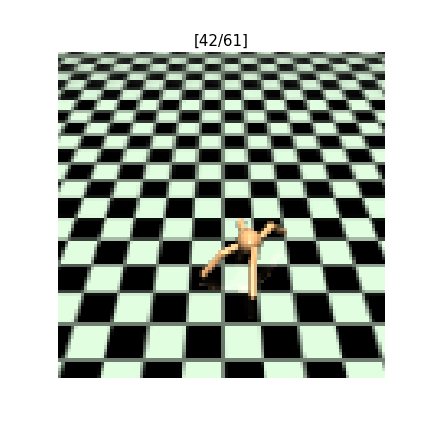
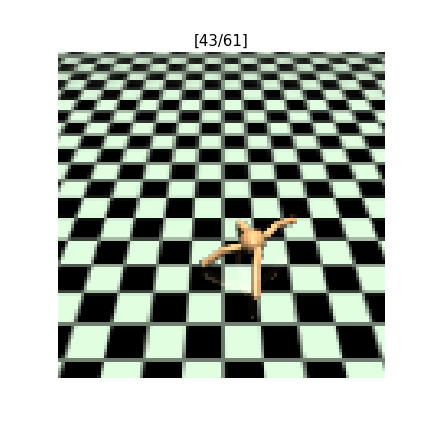
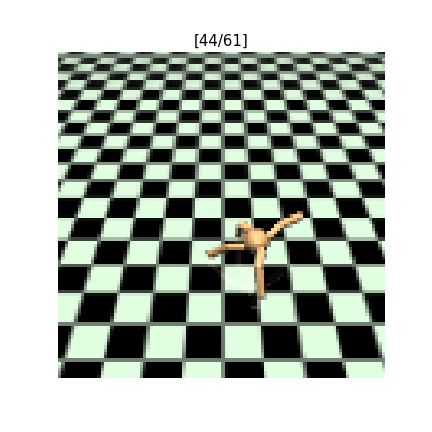
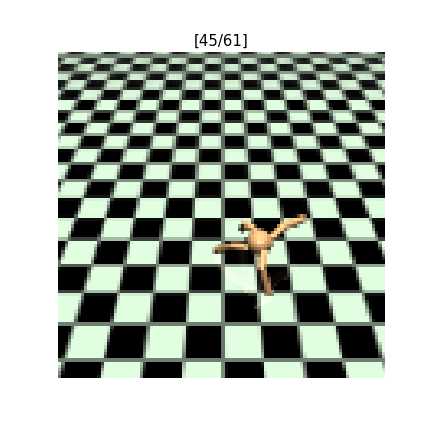
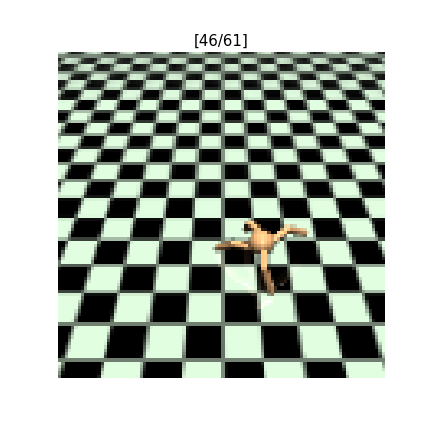
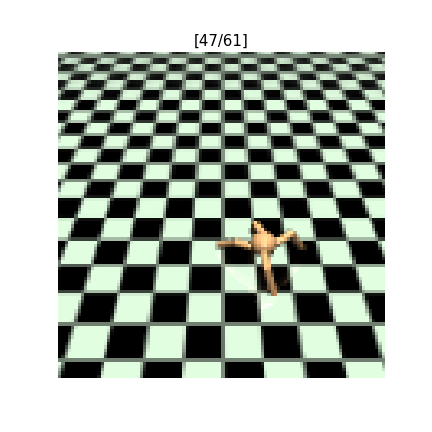
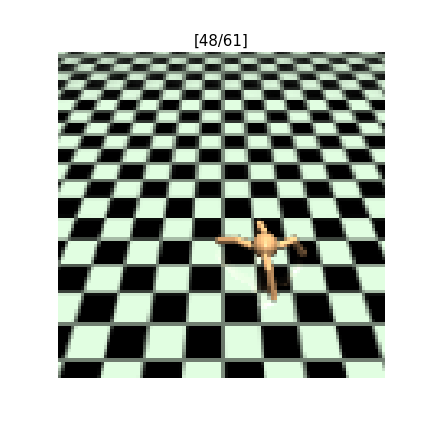
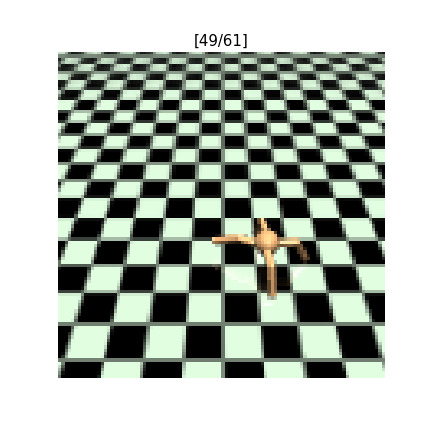
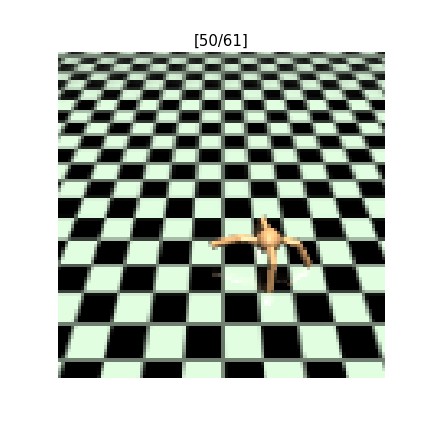
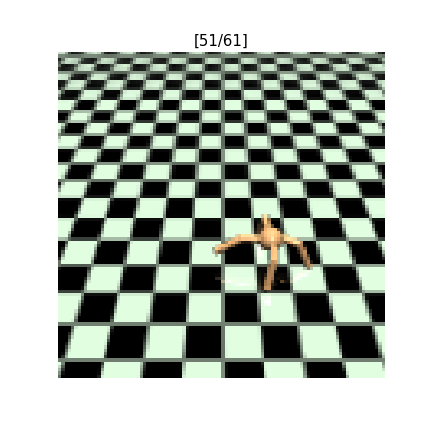
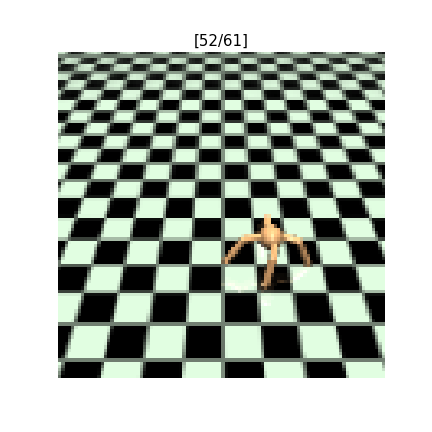
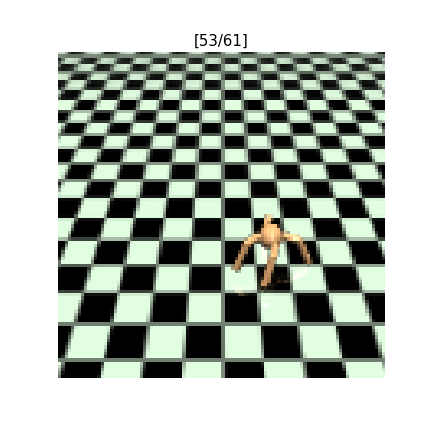
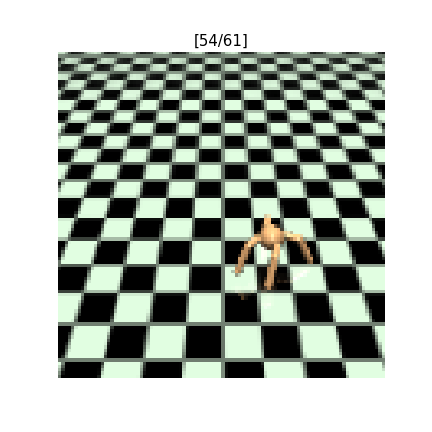
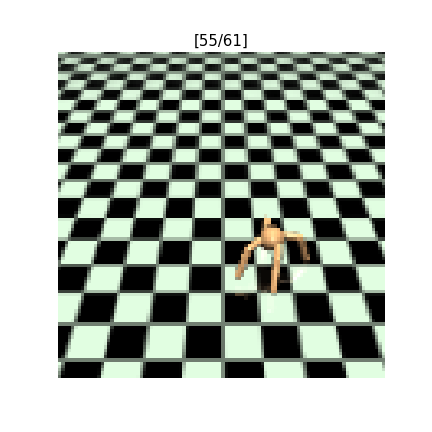
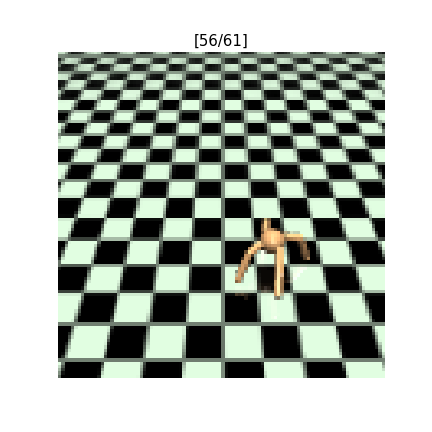
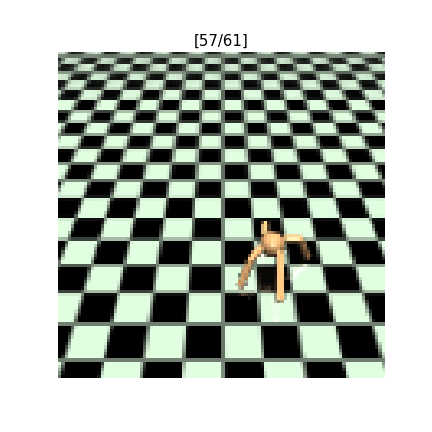
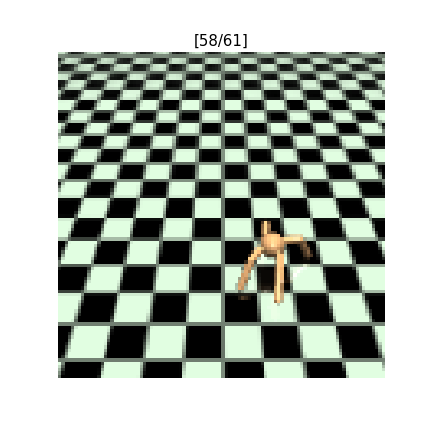
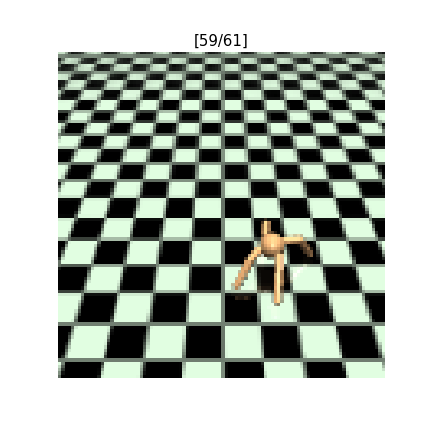
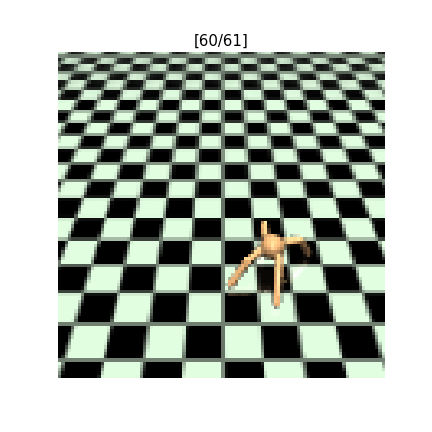

[vids/ant_ppo_final_0.mp4] saved.
Total reward: [16.00355]



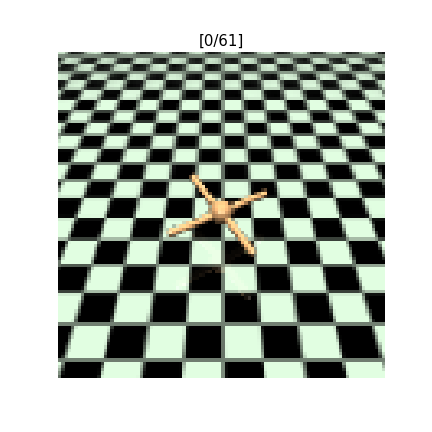
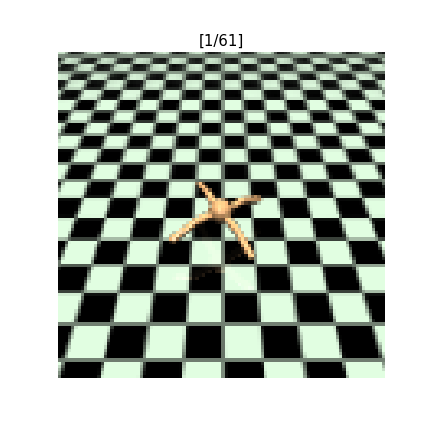
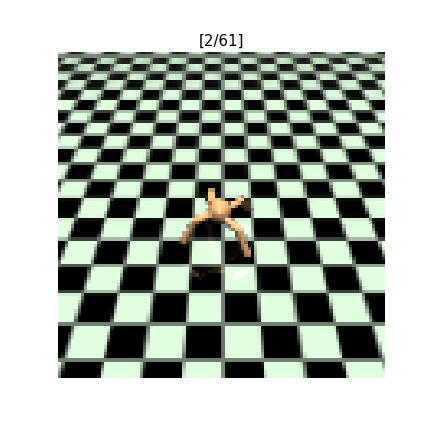
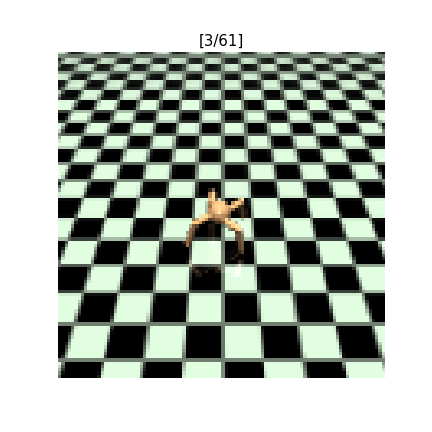
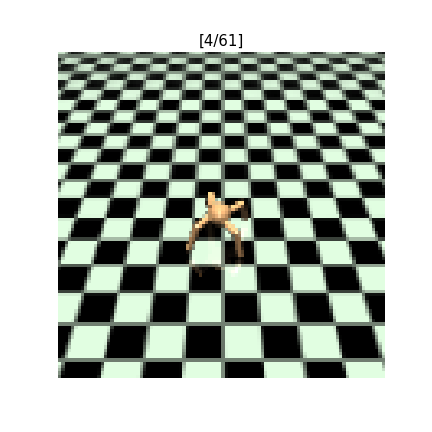
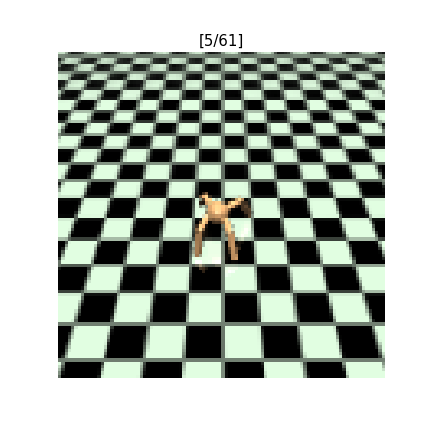
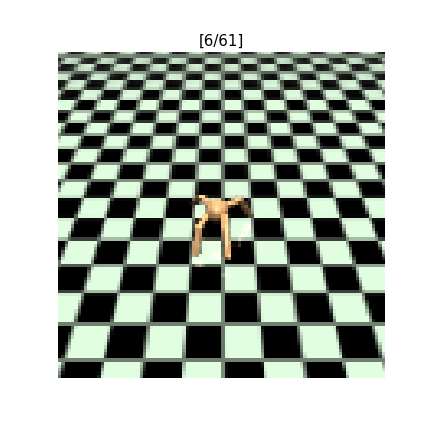
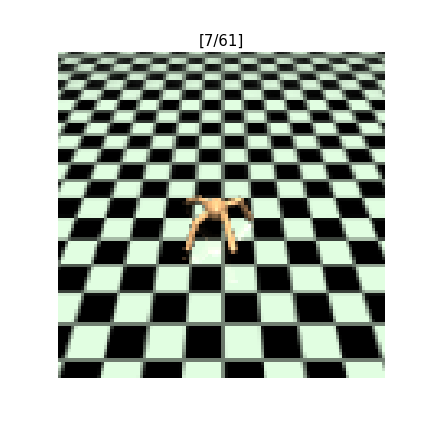
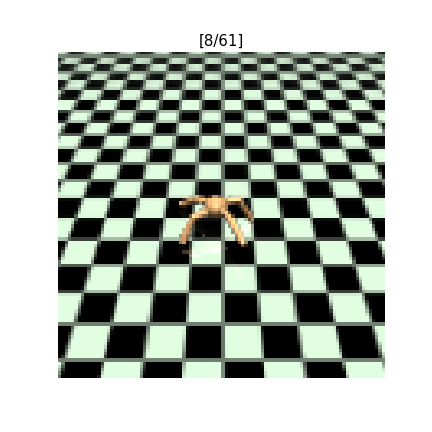
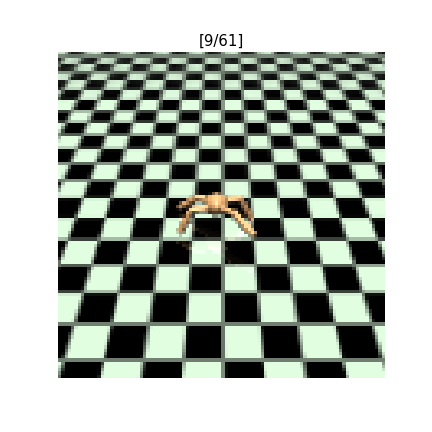
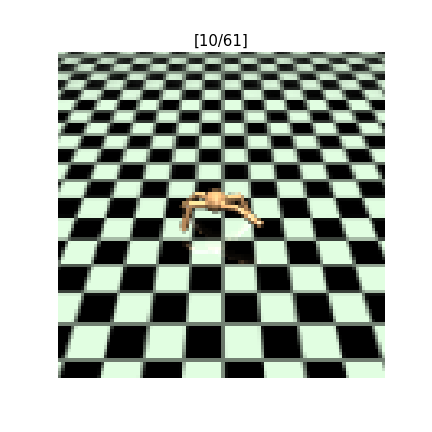
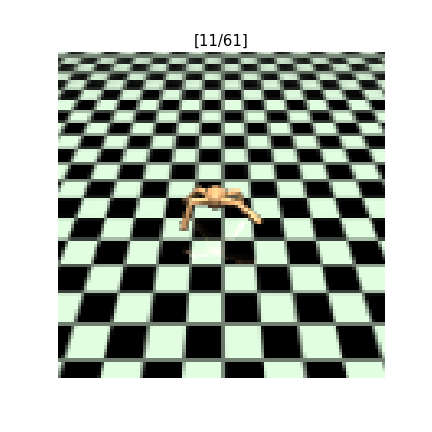
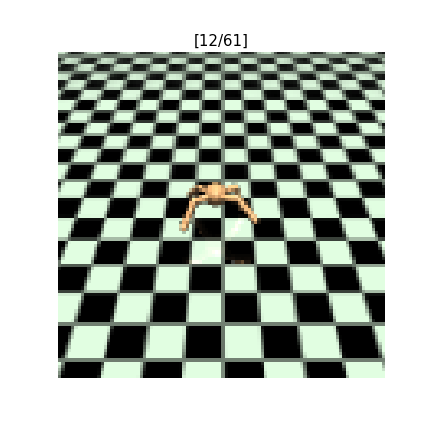
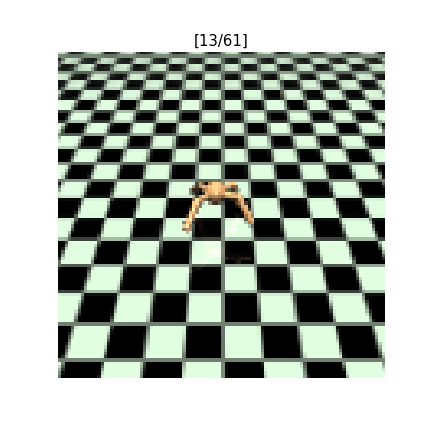
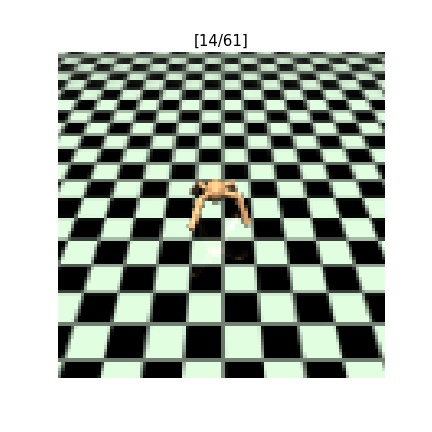
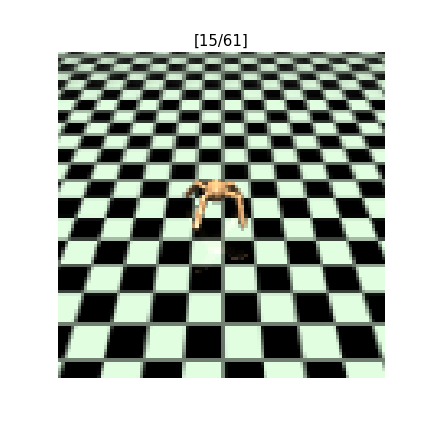
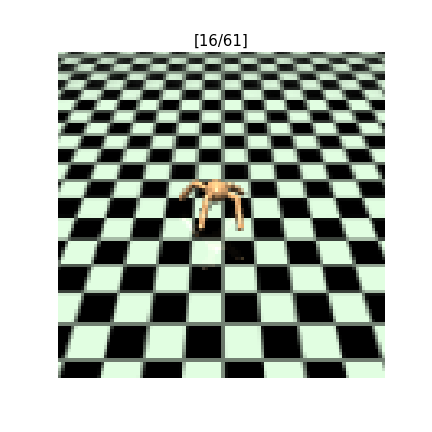
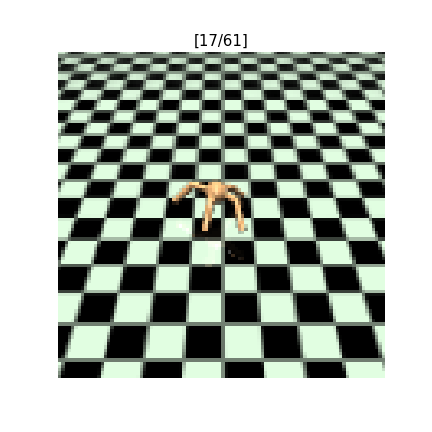
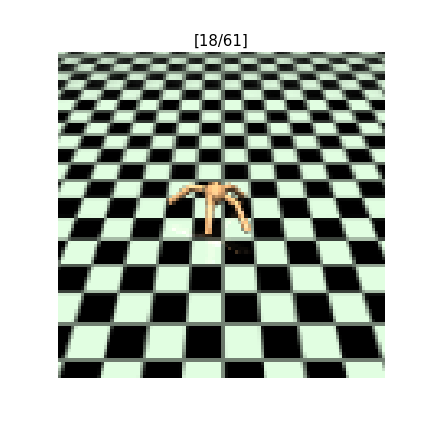
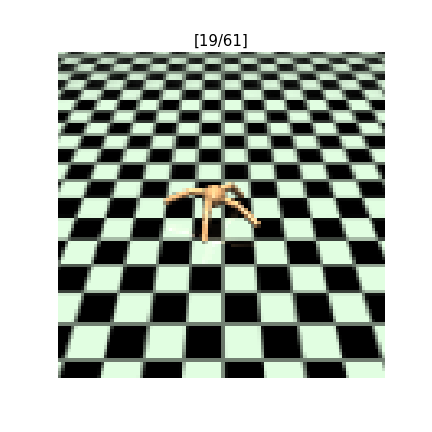
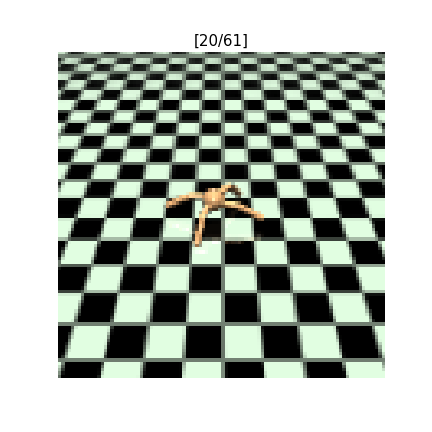
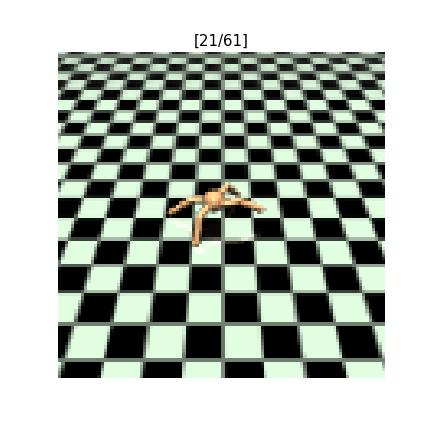
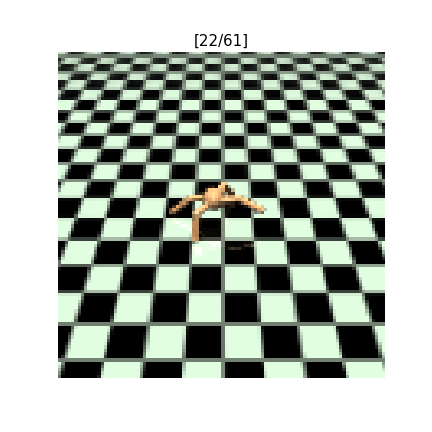
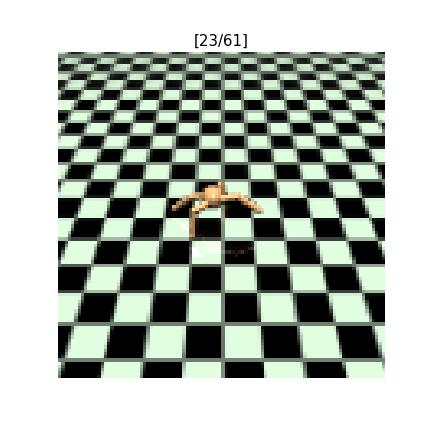
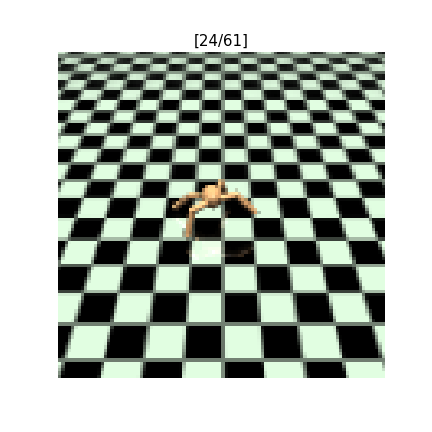
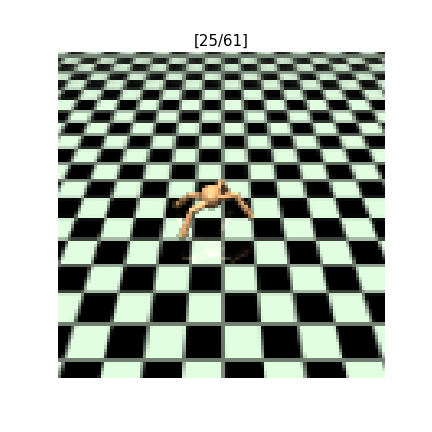
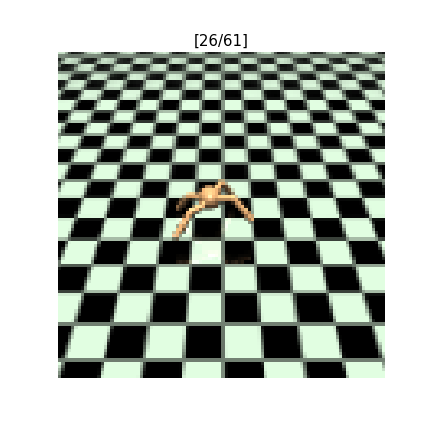
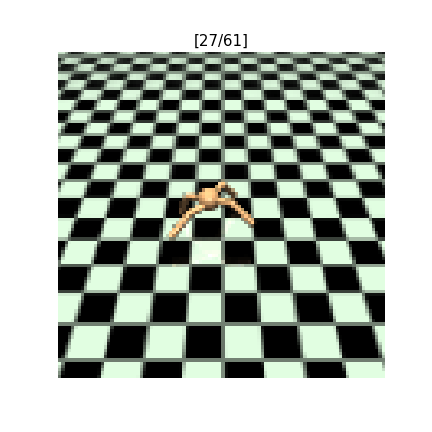
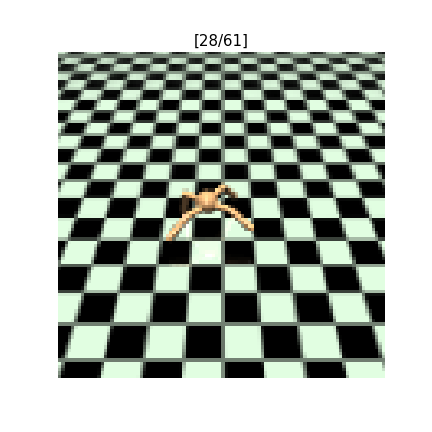
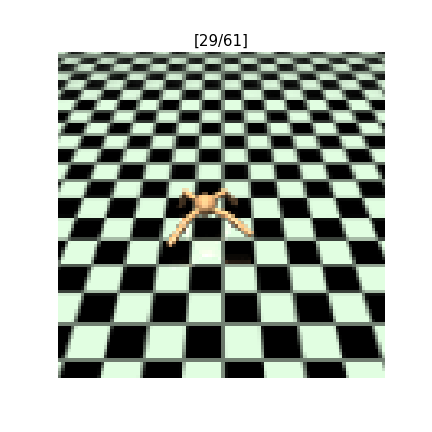
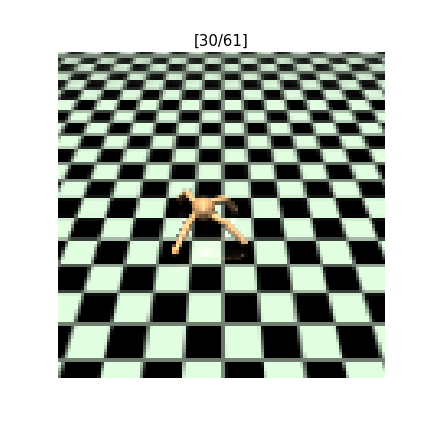
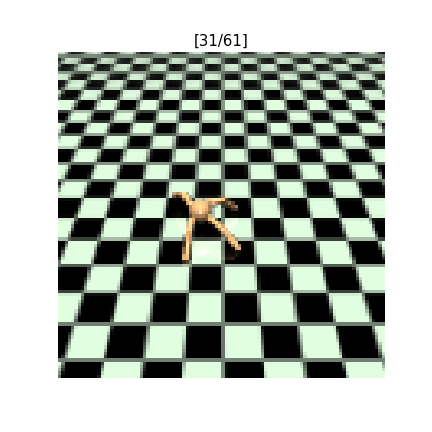
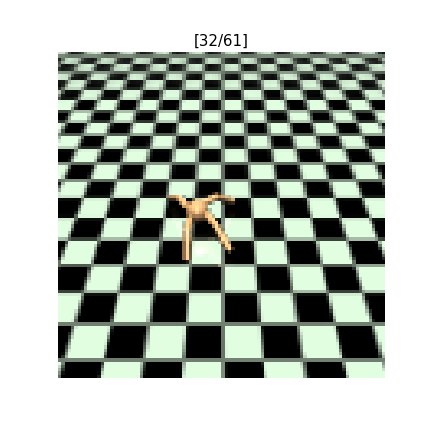
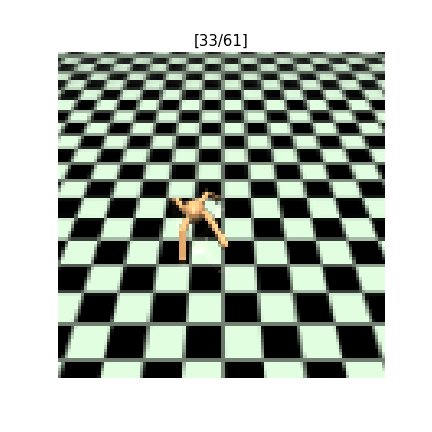
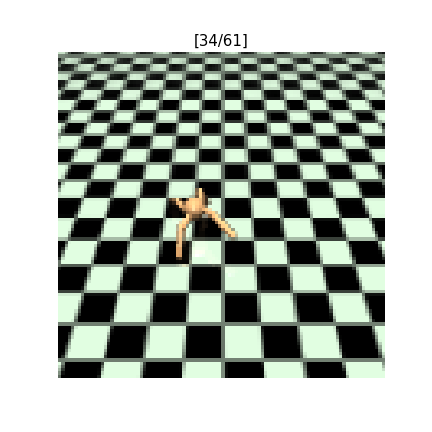
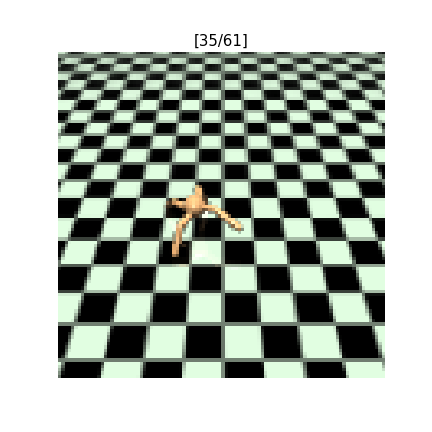
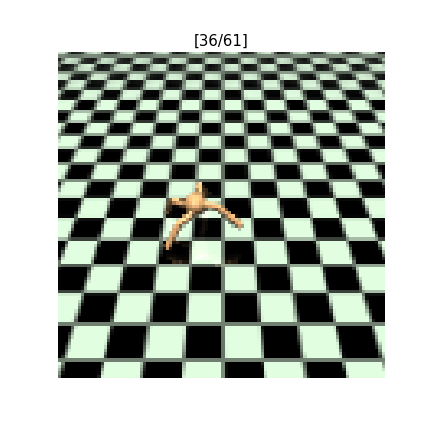
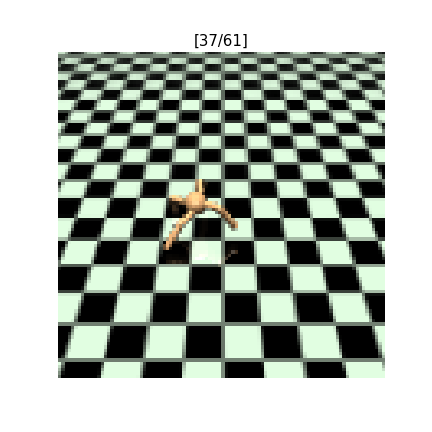
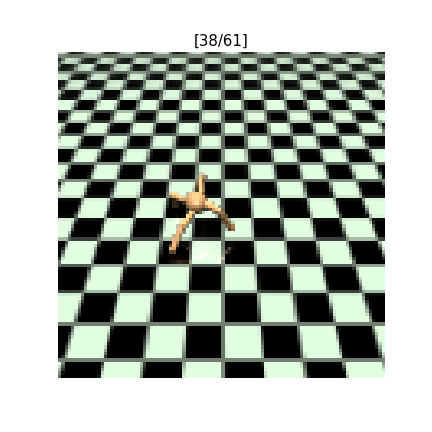
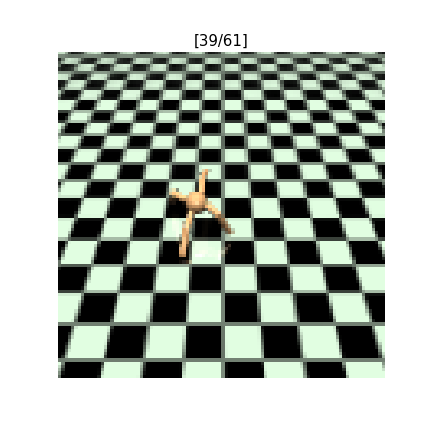
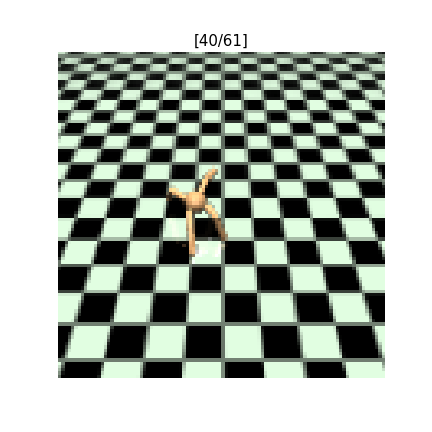
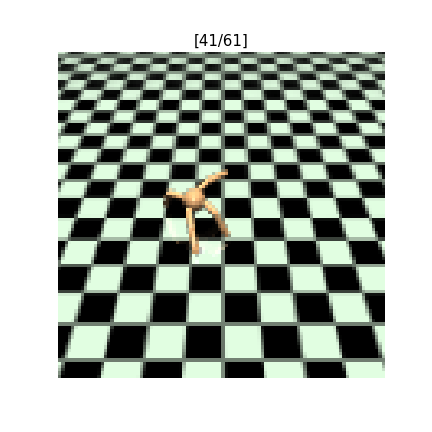
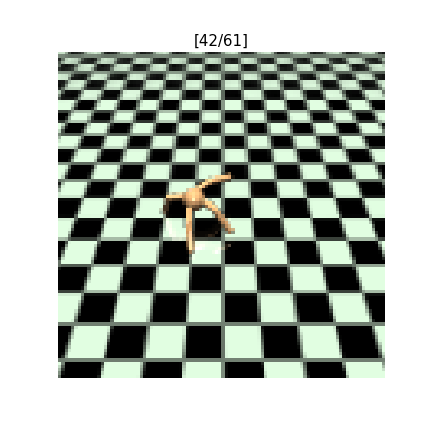
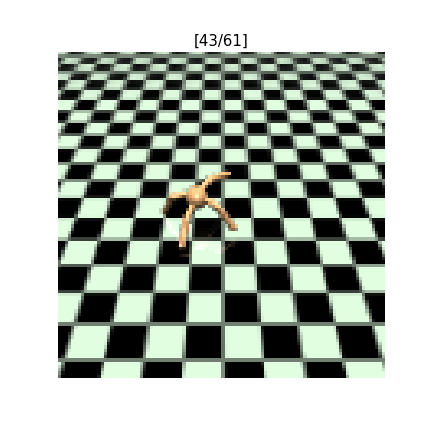
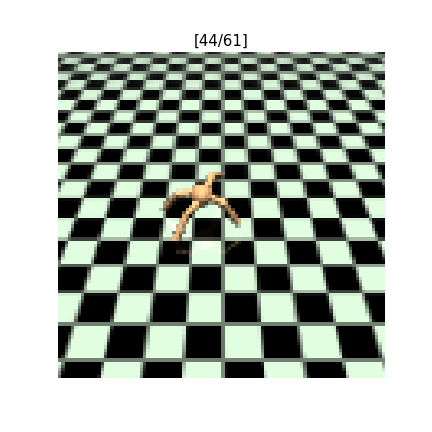
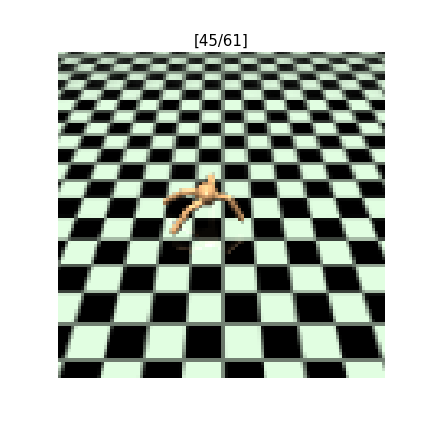
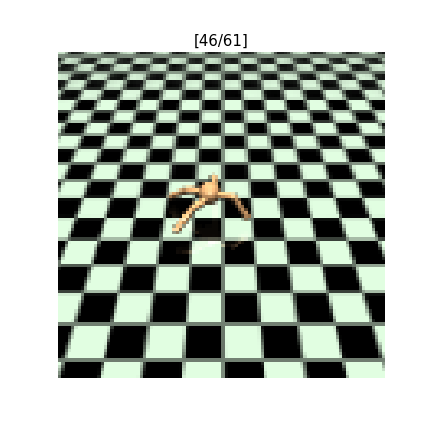
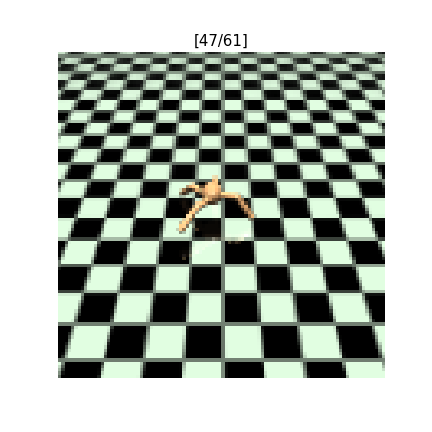
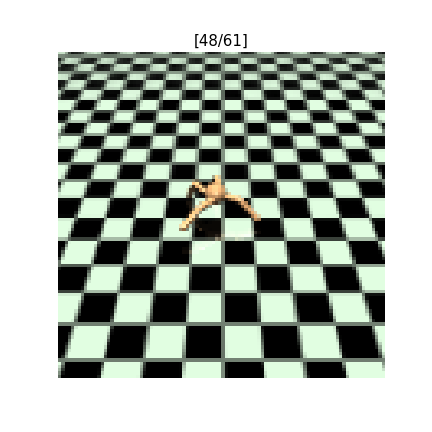
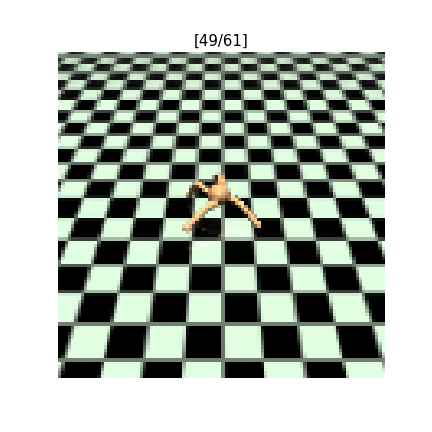
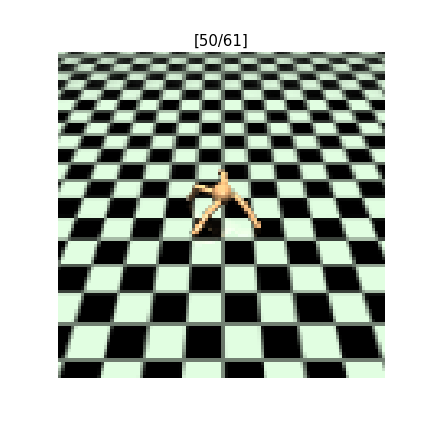
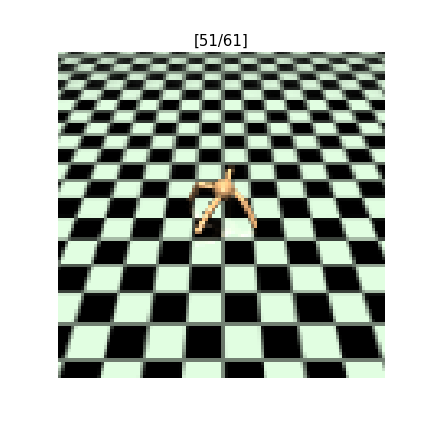
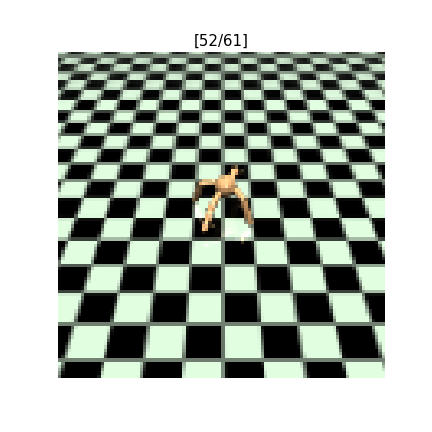
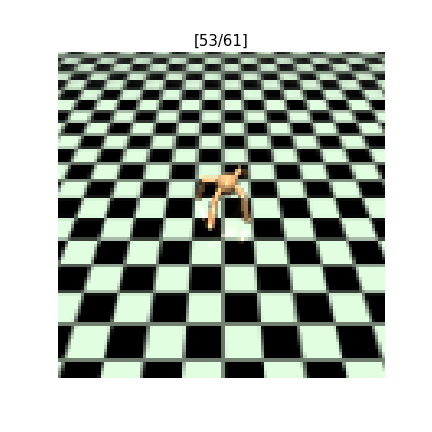
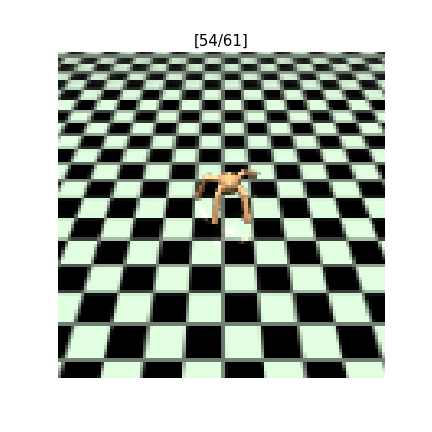
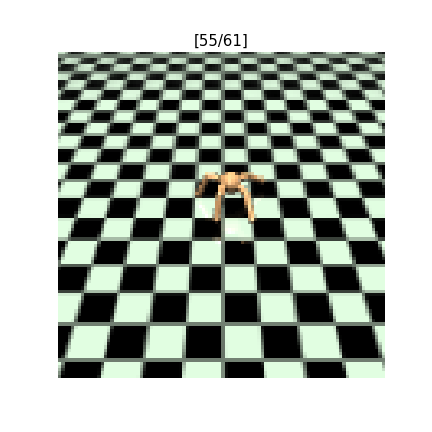
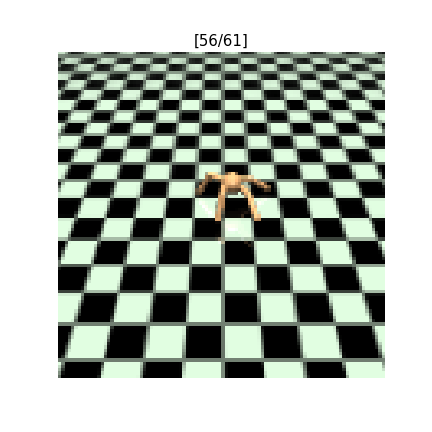
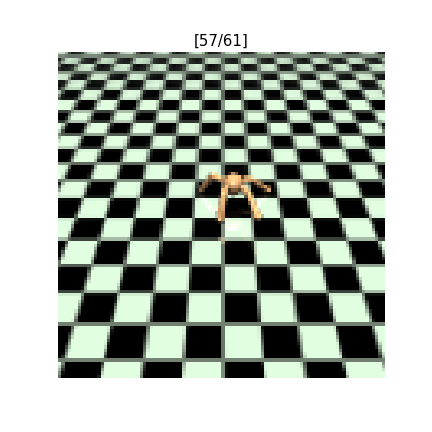
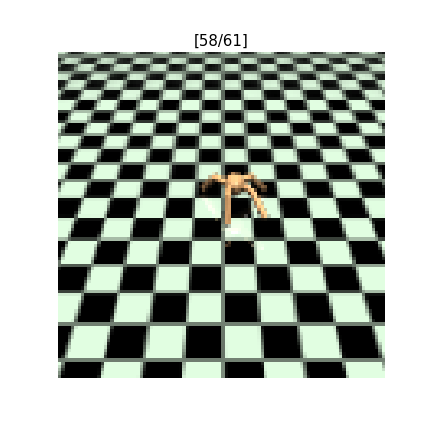
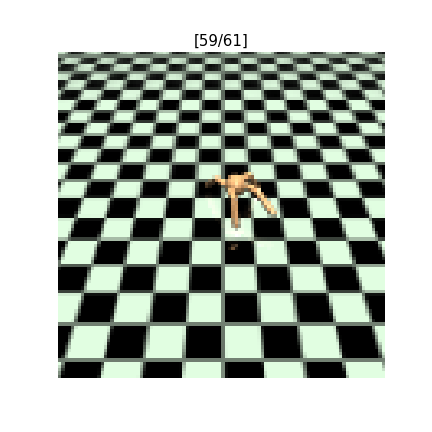
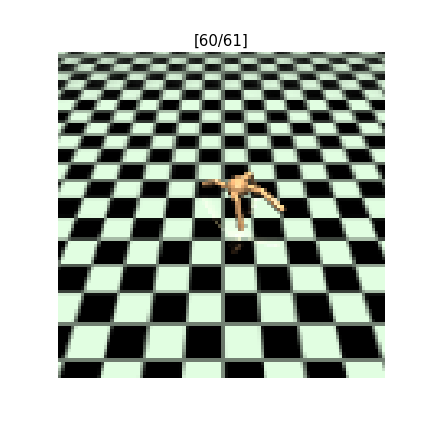

[vids/ant_ppo_final_1.mp4] saved.


In [19]:
import skvideo.io
for i in range(2):
    frames = run_episode_vid(env, policy, scaler)
    display_frames_as_gif(frames)
    outputdata = np.asarray(frames).astype(np.uint8)
    vidName = 'vids/ant_ppo_final_%d.mp4'%(i)
    skvideo.io.vwrite(vidName, outputdata)
    print ("[%s] saved."%(vidName))

### Finished

In [20]:
DO_CLOSE = False # There is no turning back. 
if DO_CLOSE:
    logger.close()
    policy.close_sess()
    val_func.close_sess()